In [1]:
# Pasting these here for easier access

import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 

In [2]:
# Checking if we are in the correct directory
#wd()

# Define the range for weight groups
min_weight = 6
max_weight = 60

# Define pmax_art values
weight_values = list(range(min_weight, max_weight+1, 1))
print(weight_values)
print(len(weight_values))

#Saving EC50_lum for future reference
np.savetxt('pkpd_AL_weight_calibration_weight_range_01.txt', weight_values, delimiter=',', fmt='%5f')

# Initialize a grid to store the clearance rates
trial_efficacy = np.zeros(len(weight_values))

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
55


In [3]:
def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "--pmax_artemether","0.999999",
        "-n", "1000",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    trial_efficacy[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file

df.to_pickle("pkpd_AL_weight_calibration_01.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_calibration_01.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 55/55 [04:03<00:00,  4.42s/it]  

DataFrame saved as pickle and CSV files successfully.


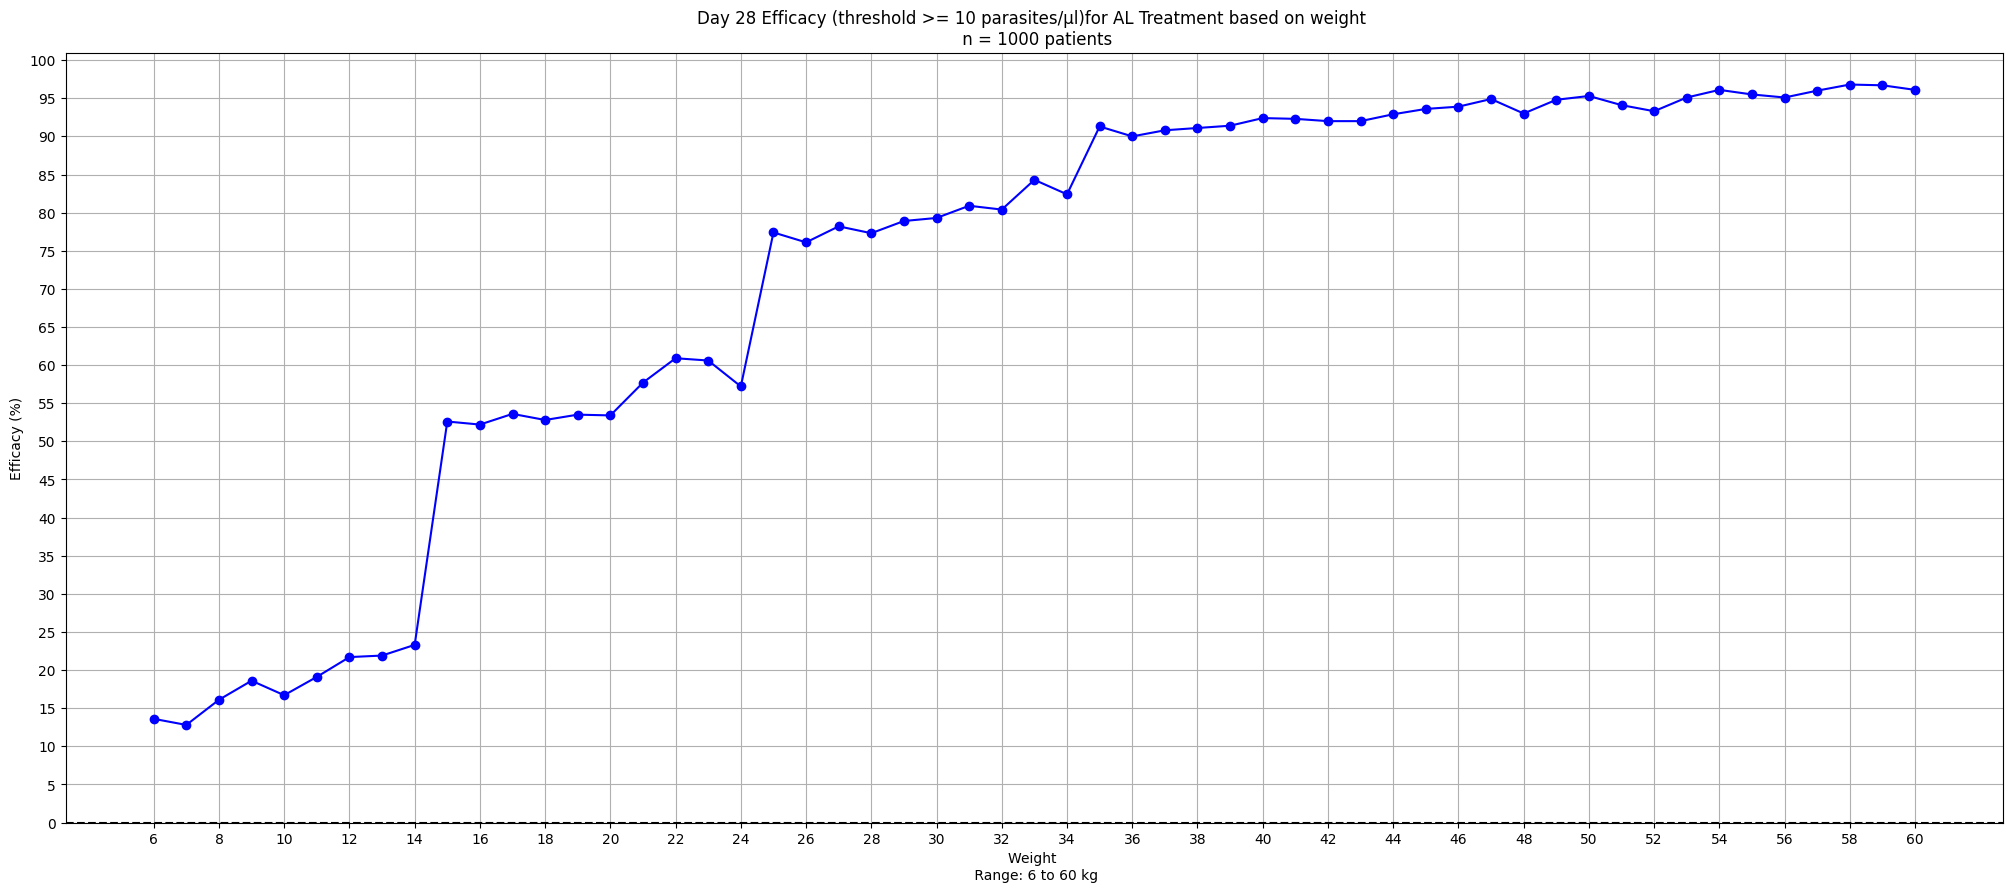

In [5]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, trial_efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('Weight \n Range: 6 to 60 kg')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl)for AL Treatment based on weight \n n = 1000 patients")
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_calibration_01.png")  # Save the plot as a PNG file
plt.show()

In [8]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--pmax_artemether", "0.999999",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 10  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_group_01_10kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_group_01_10kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  821
The percentage efficacy is:  17.900000000000006

Today's date:  2025-03-31 

Length of simulation:  0:00:25.506955 



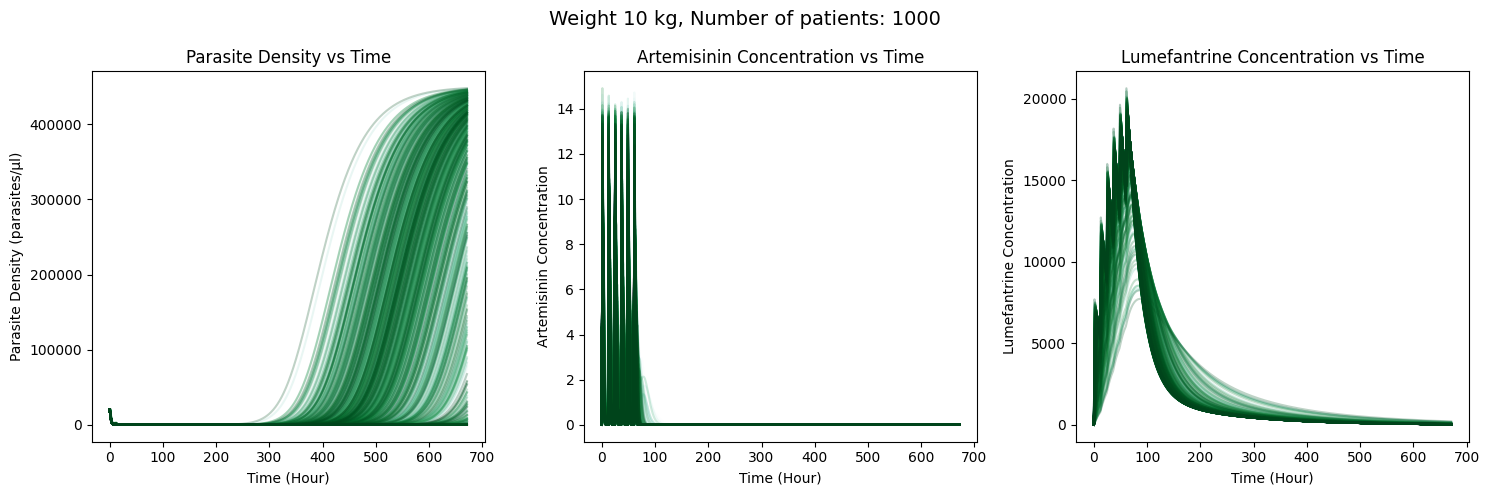

In [ ]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range



plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration')
plt.title('Artemether Concentration vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids}", fontsize=14)
plt.tight_layout()
plt.savefig("df_weight_10kg.png")
plt.show()


In [4]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--pmax_artemether", "0.999999",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 15  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_15kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_15kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  504
The percentage efficacy is:  49.6

Today's date:  2025-03-31 

Length of simulation:  0:00:25.602691 



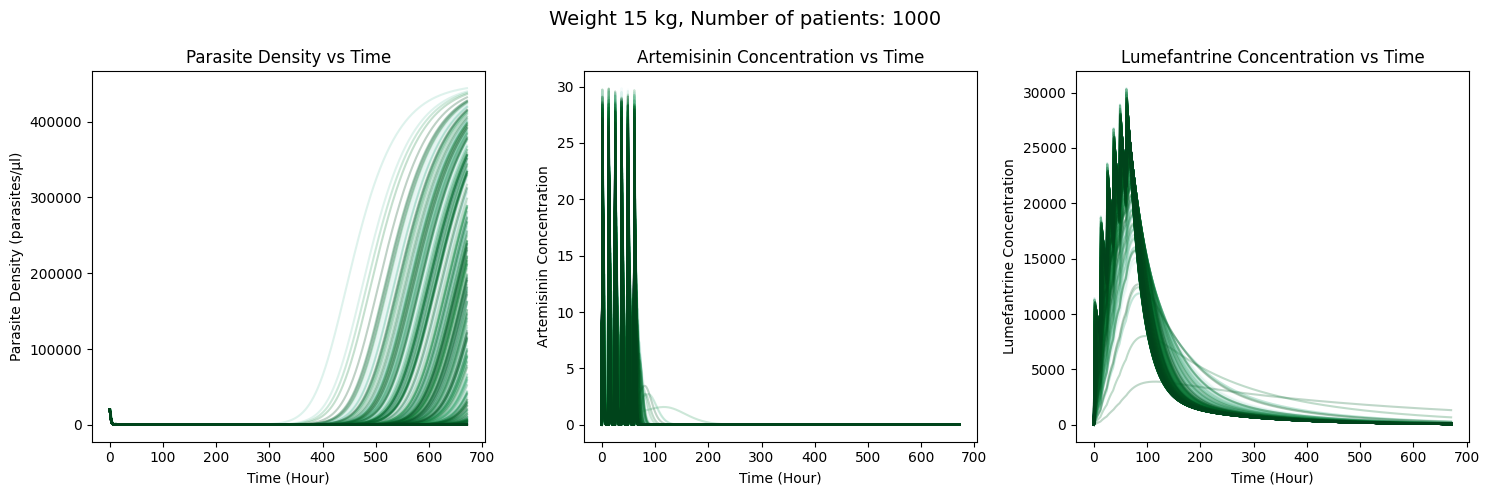

In [ ]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range



plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration')
plt.title('Artemether Concentration vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids}", fontsize=14)
plt.tight_layout()
plt.savefig("df_weight_15kg.png")
plt.show()


In [6]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--pmax_artemether", "0.999999",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 20  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_20kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_20kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  459
The percentage efficacy is:  54.1

Today's date:  2025-03-31 

Length of simulation:  0:00:26.571745 



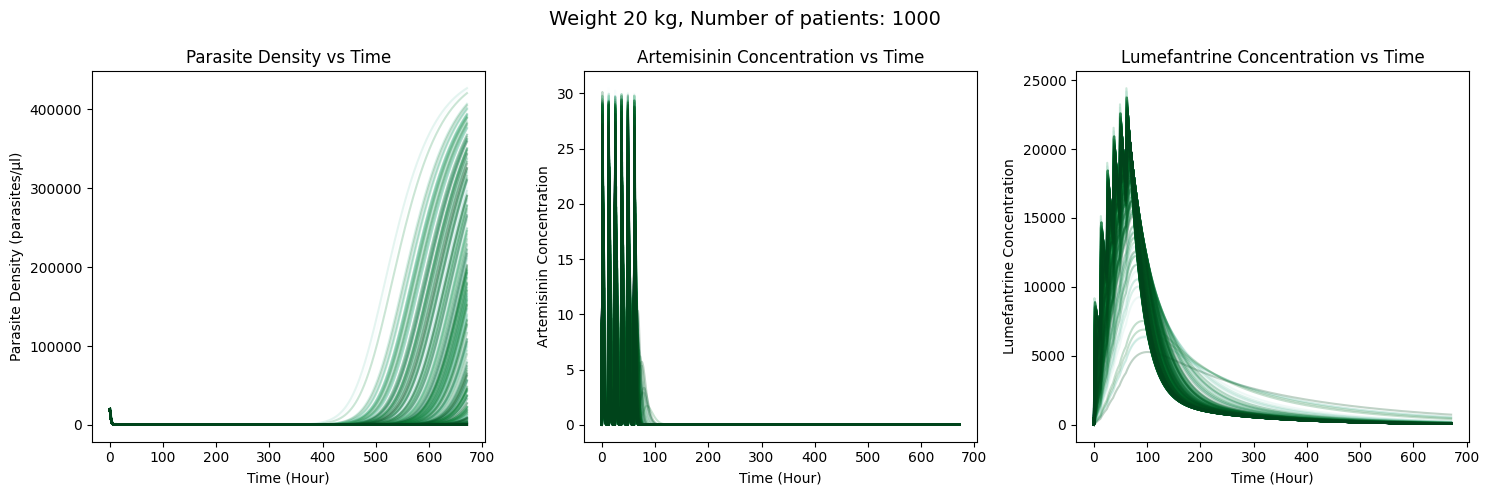

In [ ]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range



plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration')
plt.title('Artemether Concentration vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids}", fontsize=14)
plt.tight_layout()
plt.savefig("df_weight_20kg.png")
plt.show()


In [8]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--pmax_artemether", "0.999999",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 30  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_30kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_30kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  187
The percentage efficacy is:  81.3

Today's date:  2025-03-31 

Length of simulation:  0:00:25.860880 



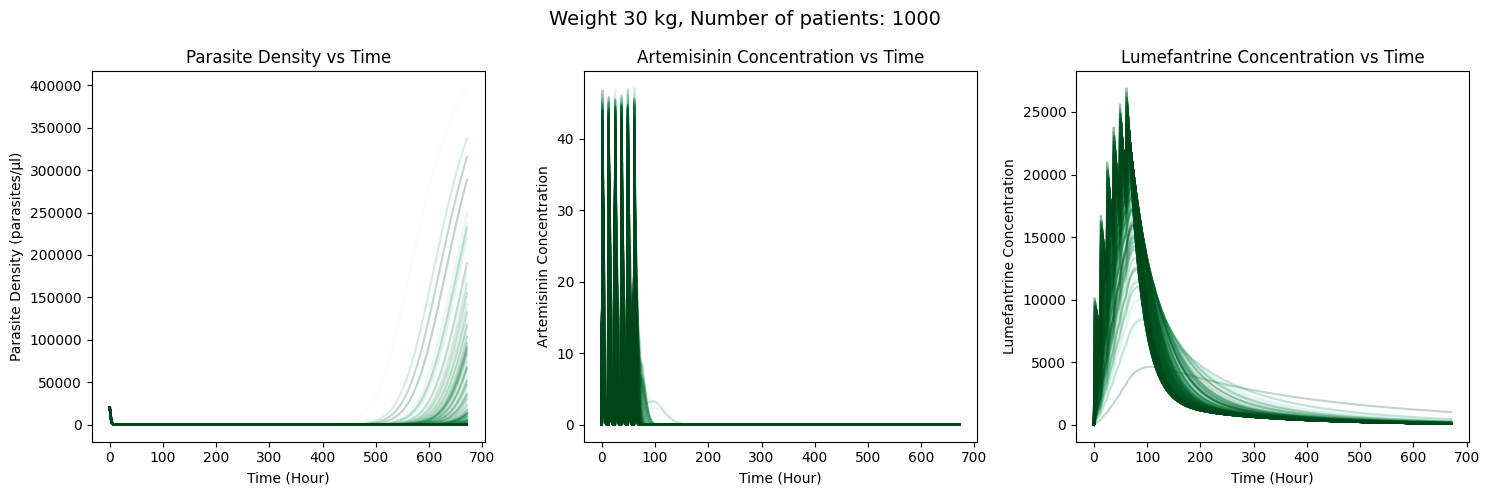

In [ ]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range



plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration')
plt.title('Artemether Concentration vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids}", fontsize=14)
plt.tight_layout()
plt.savefig("df_weight_30kg.png")
plt.show()


In [10]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--pmax_artemether", "0.999999",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 40  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_40kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_40kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  83
The percentage efficacy is:  91.7

Today's date:  2025-03-31 

Length of simulation:  0:00:25.381267 



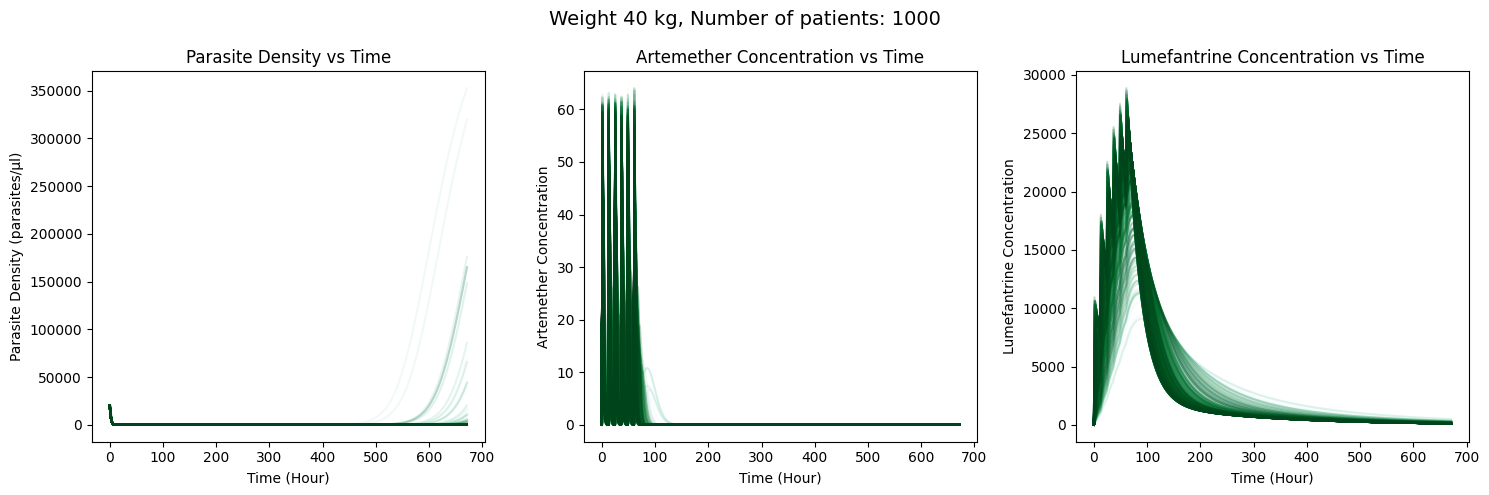

In [12]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range



plt.subplot(1, 3, 1)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration')
plt.title('Artemether Concentration vs Time')

plt.subplot(1, 3, 3)
for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
#plt.plot(df_weight['HOUR'], df_weight['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration')
plt.title('Lumefantrine Concentration vs Time')

# Add title for the entire figure
plt.suptitle(f"Weight {weight} kg, Number of patients: {num_pids}", fontsize=14)
plt.tight_layout()
plt.savefig("df_weight_40kg.png")
plt.show()


In [53]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataframes
df_weight_10 = pd.read_pickle("df_weight_group_01_10kg.pyobj")
df_weight_15 = pd.read_pickle("df_weight_15kg.pyobj")
df_weight_20 = pd.read_pickle("df_weight_20kg.pyobj")
df_weight_30 = pd.read_pickle("df_weight_30kg.pyobj")
df_weight_40 = pd.read_pickle("df_weight_40kg.pyobj")

#Calculate the failed treatment counts
failed_treatment_count_10 = df_weight_10[(df_weight_10['PARASITEDENSITY'] >= 10) & (df_weight_10['HOUR'] == 671.0)].shape[0]
failed_treatment_count_15 = df_weight_15[(df_weight_15['PARASITEDENSITY'] >= 10) & (df_weight_15['HOUR'] == 671.0)].shape[0]
failed_treatment_count_20 = df_weight_20[(df_weight_20['PARASITEDENSITY'] >= 10) & (df_weight_20['HOUR'] == 671.0)].shape[0]
failed_treatment_count_30 = df_weight_30[(df_weight_30['PARASITEDENSITY'] >= 10) & (df_weight_30['HOUR'] == 671.0)].shape[0]
failed_treatment_count_40 = df_weight_40[(df_weight_40['PARASITEDENSITY'] >= 10) & (df_weight_40['HOUR'] == 671.0)].shape[0]

# Calculate the efficacy using the failed treatment counts
# Assuming total_patients is the same for all weights
total_patients = df_weight_10['PID'].nunique()  # Assuming same for all weights
efficacy_10 = (100 - ((failed_treatment_count_10 / total_patients) * 100)) if total_patients > 0 else 0
efficacy_15 = (100 - ((failed_treatment_count_15 / total_patients) * 100)) if total_patients > 0 else 0
efficacy_20 = (100 - ((failed_treatment_count_20 / total_patients) * 100)) if total_patients > 0 else 0
efficacy_30 = (100 - ((failed_treatment_count_30 / total_patients) * 100)) if total_patients > 0 else 0
efficacy_40 = (100 - ((failed_treatment_count_40 / total_patients) * 100)) if total_patients > 0 else 0

# Create a DataFrame for efficacies
efficacies = {
    'weight': [10, 15, 20, 30, 40],
    'efficacy': [efficacy_10, efficacy_15, efficacy_20, efficacy_30, efficacy_40]
}
df_efficacies = pd.DataFrame(efficacies)
# Save the DataFrame to a pickle file
df_efficacies.to_pickle("df_efficacies.pyobj")
# Save the DataFrame to a CSV file
df_efficacies.to_csv("df_efficacies.csv", index=False)

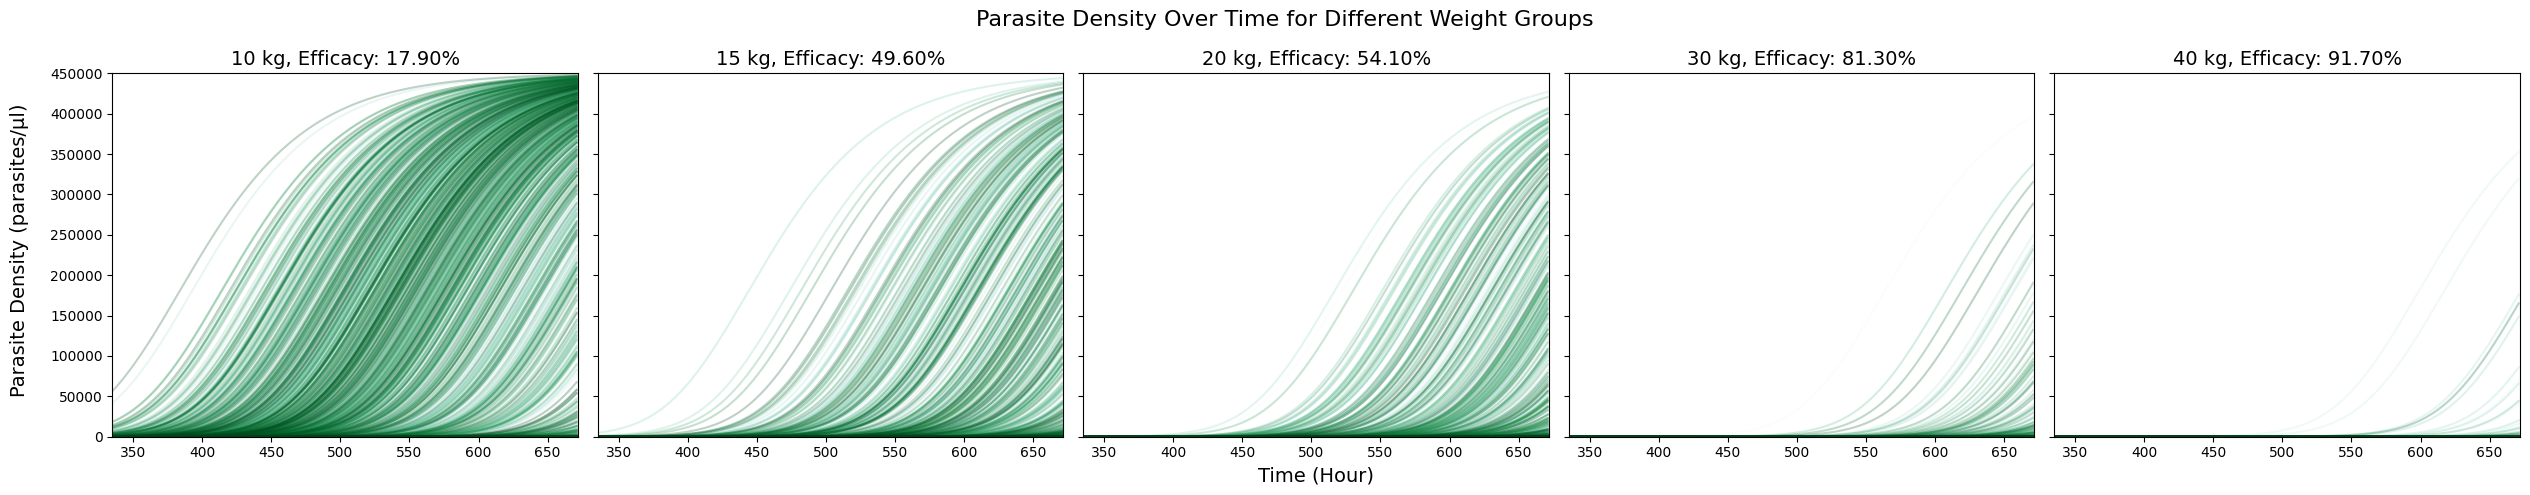

In [87]:
# Store DataFrames in a dictionary
df_dict = {10: df_weight_10, 15: df_weight_15, 20: df_weight_20, 30: df_weight_30, 40: df_weight_40}

# Create a 1x5 subplot with shared axes
fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

# Define colormap
colormap = plt.get_cmap('BuGn')

# Iterate over each weight category
for i, weight in enumerate([10, 15, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Set subplot title
    ax[i].set_title(f'{weight} kg, Efficacy: {df_efficacies[df_efficacies["weight"] == weight]["efficacy"].values[0]:.2f}%', fontsize=14)

    # Plot parasite density for each PID
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = colormap(norm(j))  # Assign color
        ax[i].plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
    ax[i].set_ylim(0, 450000)
    # Set x-axis limits to 0 - 672
    ax[i].set_xlim(335, 672)
    # Show x-label only on the bottom subplots
    if i == 2:  # Middle subplot (for better centering)
        ax[i].set_xlabel('Time (Hour)', fontsize=14)

# Add common y-axis label
fig.text(-0.01, 0.5, 'Parasite Density (parasites/μl)', va='center', rotation='vertical', fontsize=14)
# Add a common title
fig.suptitle('Parasite Density Over Time for Different Weight Groups', fontsize=16)

plt.tight_layout()
plt.savefig("df_weight_parasite_density_week2_onwards.png")
plt.show()


In [ ]:
# Store DataFrames in a dictionary
df_dict = {10: df_weight_10, 15: df_weight_15, 20: df_weight_20, 30: df_weight_30, 40: df_weight_40}

# Create a 1x5 subplot with shared axes
fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

# Define colormap
colormap = plt.get_cmap('BuGn')

# Iterate over each weight category
for i, weight in enumerate([10, 15, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Set subplot title
    ax[i].set_title(f'{weight} kg, Efficacy: {df_efficacies[df_efficacies["weight"] == weight]["efficacy"].values[0]:.2f}%', fontsize=14)

    # Plot parasite density for each PID
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = colormap(norm(j))  # Assign color
        ax[i].plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
    # Set x-axis limits to 0 - 672
    ax[i].set_xlim(0, 672)
    # Show x-label only on the bottom subplots
    if i == 2:  # Middle subplot (for better centering)
        ax[i].set_xlabel('Time (Hour)', fontsize=14)

# Add common y-axis label
fig.text(-0.01, 0.5, 'Parasite Density (parasites/μl)', va='center', rotation='vertical', fontsize=14)
# Add a common title
fig.suptitle('Parasite Density Over Time for Different Weight Groups', fontsize=16)

plt.tight_layout()
plt.savefig("df_weight_parasite_density.png")
plt.show()


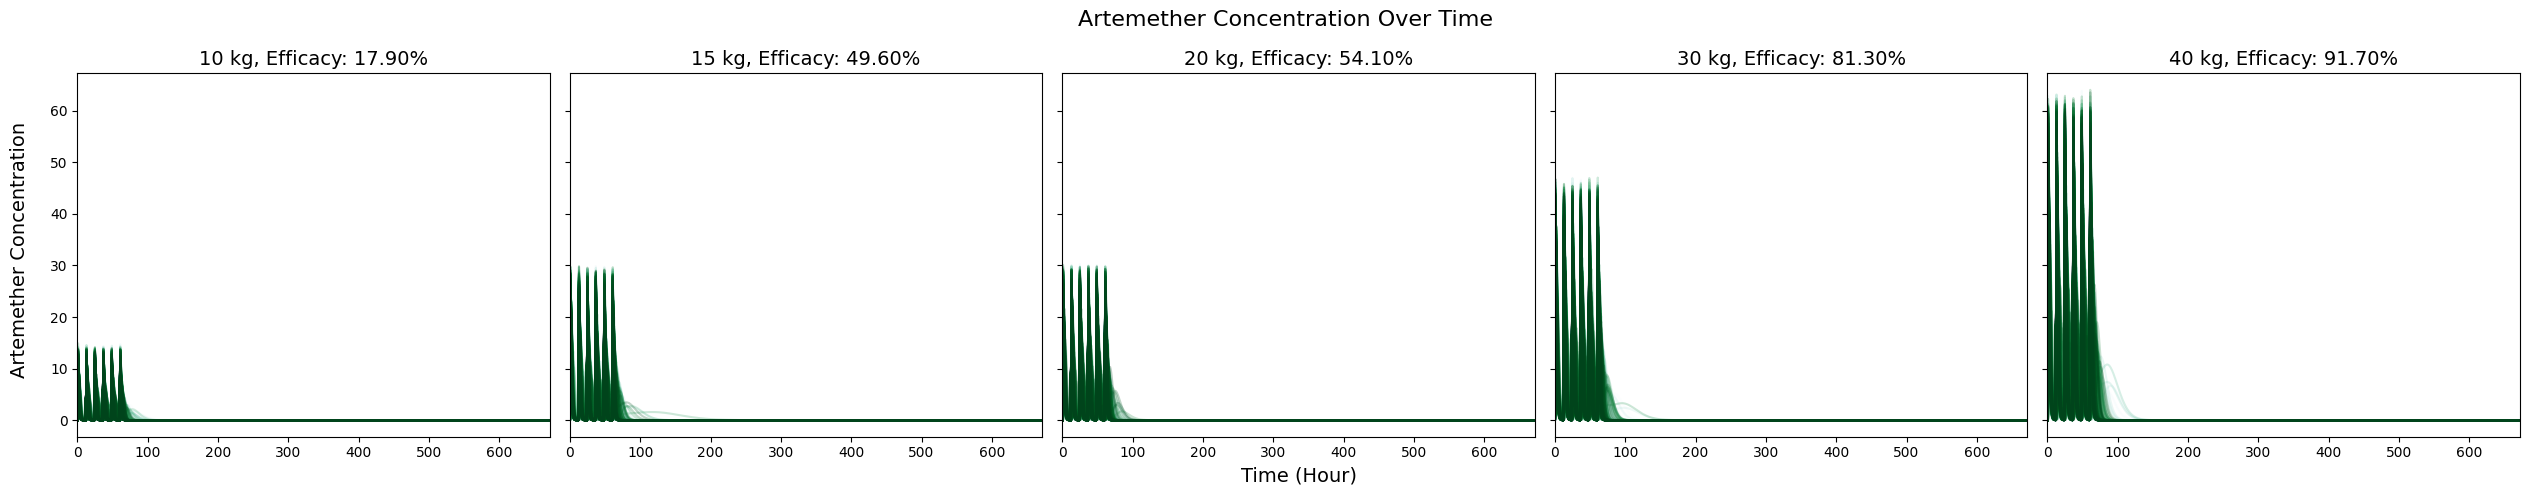

In [59]:
#Repeating the process for artemether concentration
# Store DataFrames in a dictionary
df_dict = {10: df_weight_10, 15: df_weight_15, 20: df_weight_20, 30: df_weight_30, 40: df_weight_40}

# Create a 1x5 subplot with shared axes
fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

# Define colormap
colormap = plt.get_cmap('BuGn')

# Iterate over each weight category
for i, weight in enumerate([10, 15, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Set subplot title
    ax[i].set_title(f'{weight} kg, Efficacy: {df_efficacies[df_efficacies["weight"] == weight]["efficacy"].values[0]:.2f}%', fontsize=14)

    # Plot parasite density for each PID
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = colormap(norm(j))  # Assign color
        ax[i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)
    # Set x-axis limits to 0 - 672
    ax[i].set_xlim(0, 672)
    # Show x-label only on the bottom subplots
    if i == 2:  # Middle subplot (for better centering)
        ax[i].set_xlabel('Time (Hour)', fontsize=14)

# Add common y-axis label
fig.text(-0.01, 0.5, 'Artemether Concentration', va='center', rotation='vertical', fontsize=14)
# Add a common title
fig.suptitle('Artemether Concentration Over Time', fontsize=16)

plt.tight_layout()
plt.savefig("df_weight_artemether_concentration.png")
plt.show()


In [ ]:
#Repeating the process for artemether concentration
# Store DataFrames in a dictionary
df_dict = {10: df_weight_10, 15: df_weight_15, 20: df_weight_20, 30: df_weight_30, 40: df_weight_40}

# Create a 1x5 subplot with shared axes
fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

# Define colormap
colormap = plt.get_cmap('BuGn')

# Iterate over each weight category
for i, weight in enumerate([10, 15, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Set subplot title
    ax[i].set_title(f'{weight} kg, Efficacy: {df_efficacies[df_efficacies["weight"] == weight]["efficacy"].values[0]:.2f}%', fontsize=14)

    # Plot parasite density for each PID
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = colormap(norm(j))  # Assign color
        ax[i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)
    # Set x-axis limits to 0 - 672
    ax[i].set_xlim(0, 672)
    # Show x-label only on the bottom subplots
    if i == 2:  # Middle subplot (for better centering)
        ax[i].set_xlabel('Time (Hour)', fontsize=14)

# Add common y-axis label
fig.text(-0.01, 0.5, 'Artemether Concentration', va='center', rotation='vertical', fontsize=14)
# Add a common title
fig.suptitle('Artemether Concentration Over Time', fontsize=16)

plt.tight_layout()
plt.savefig("df_weight_artemether_concentration.png")
plt.show()


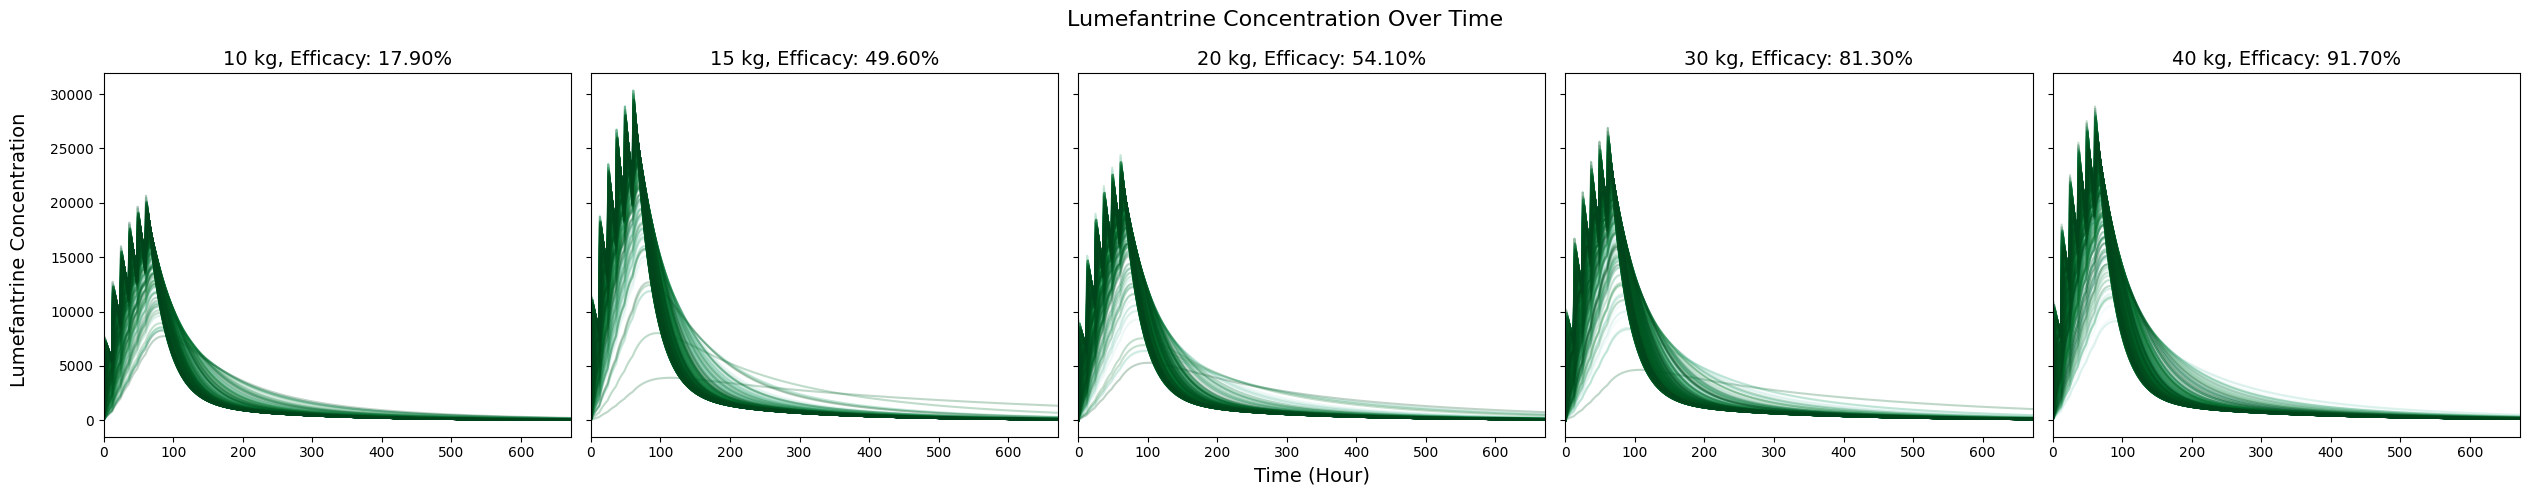

In [60]:
#Repeating the process for lumefantrine concentration
# Store DataFrames in a dictionary
df_dict = {10: df_weight_10, 15: df_weight_15, 20: df_weight_20, 30: df_weight_30, 40: df_weight_40}

# Create a 1x5 subplot with shared axes
fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

# Define colormap
colormap = plt.get_cmap('BuGn')

# Iterate over each weight category
for i, weight in enumerate([10, 15, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Set subplot title
    ax[i].set_title(f'{weight} kg, Efficacy: {df_efficacies[df_efficacies["weight"] == weight]["efficacy"].values[0]:.2f}%', fontsize=14)

    # Plot parasite density for each PID
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = colormap(norm(j))  # Assign color
        ax[i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
    # Set x-axis limits to 0 - 672
    ax[i].set_xlim(0, 672)
    # Show x-label only on the bottom subplots
    if i == 2:  # Middle subplot (for better centering)
        ax[i].set_xlabel('Time (Hour)', fontsize=14)

# Add common y-axis label
fig.text(-0.01, 0.5, 'Lumefantrine Concentration', va='center', rotation='vertical', fontsize=14)
# Add a common title
fig.suptitle('Lumefantrine Concentration Over Time', fontsize=16)

plt.tight_layout()
plt.savefig("df_weight_lumefantrine_concentration.png")
plt.show()


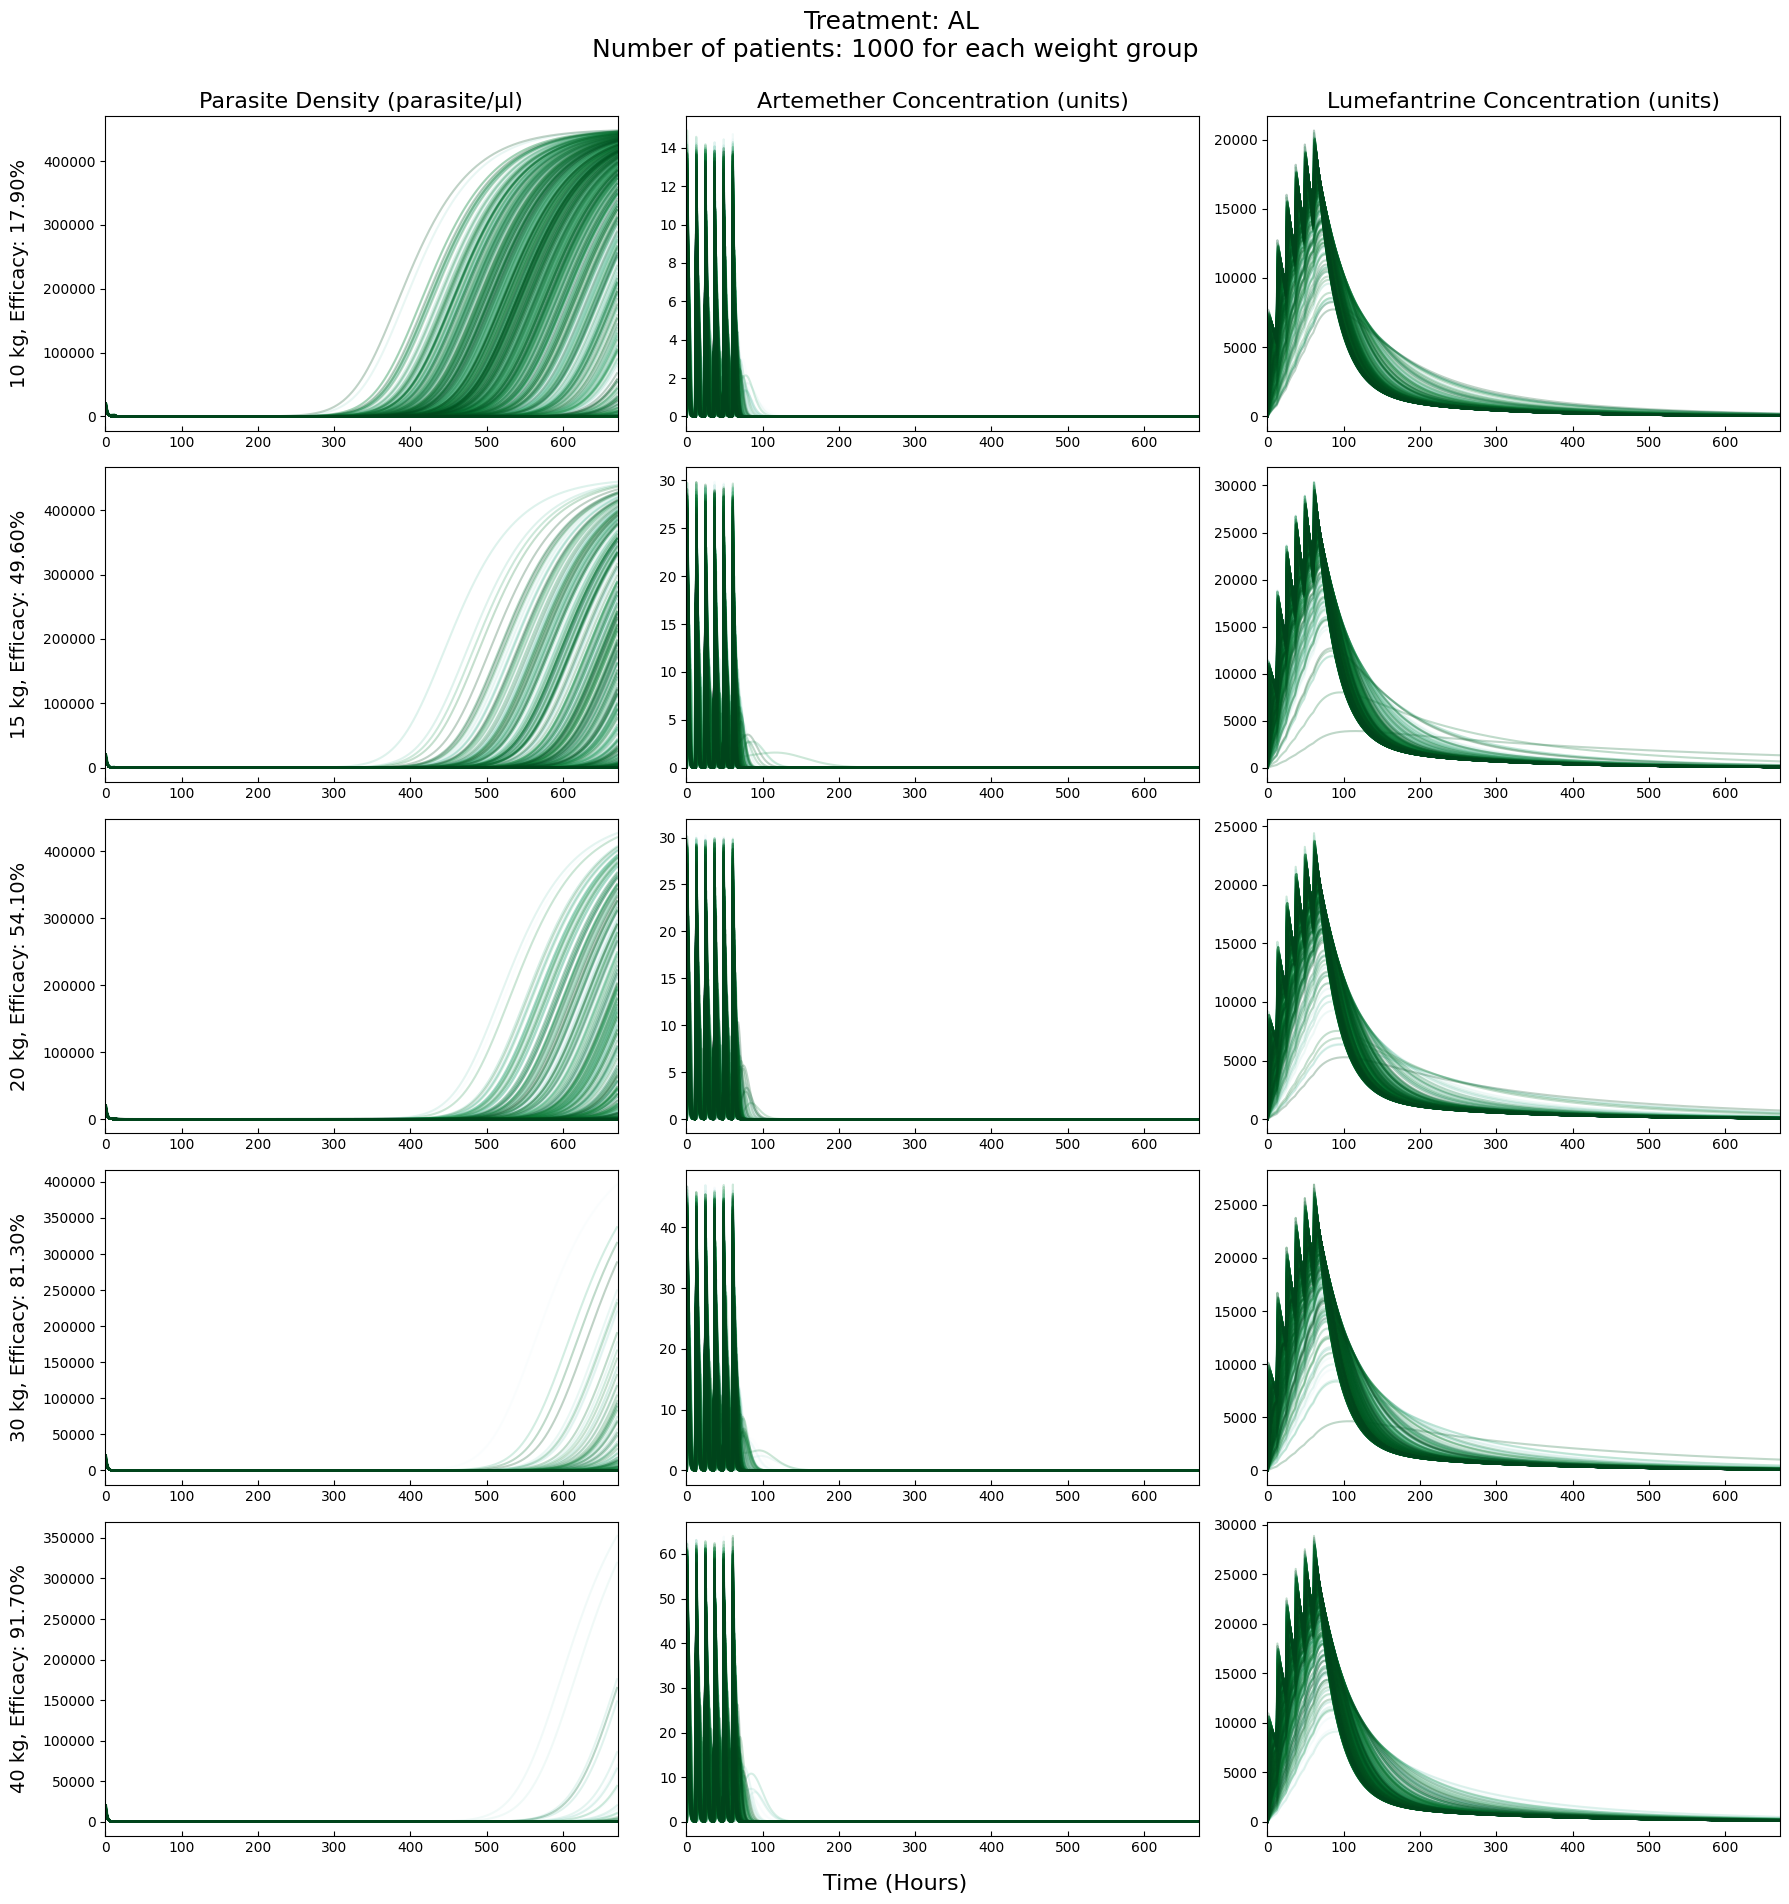

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataframes
df_weight_10 = pd.read_pickle("df_weight_group_01_10kg.pyobj")
df_weight_15 = pd.read_pickle("df_weight_15kg.pyobj")
df_weight_20 = pd.read_pickle("df_weight_20kg.pyobj")
df_weight_30 = pd.read_pickle("df_weight_30kg.pyobj")
df_weight_40 = pd.read_pickle("df_weight_40kg.pyobj")

# Store DataFrames in a dictionary
df_dict = {10: df_weight_10, 15: df_weight_15, 20: df_weight_20, 30: df_weight_30, 40: df_weight_40}

# Create a 5x3 subplot (5 weight groups, 3 variables per group)
fig, ax = plt.subplots(5, 3, figsize=(18, 20), sharex=True, sharey=False)

# Define colormap
colormap = plt.get_cmap('BuGn')

# Iterate over weight groups
for i, weight in enumerate([10, 15, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Plot Parasite Density (Column 1)
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = colormap(norm(j))
        ax[i, 0].plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)

    # Plot Artemether Concentration (Column 2)
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = colormap(norm(j))
        ax[i, 1].plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)

    # Plot Lumefantrine Concentration (Column 3)
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = colormap(norm(j))
        ax[i, 2].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)

    # Set x-axis limits
    for j in range(3):
        ax[i, j].set_xlim(0, 672)

    # Set row labels on the **leftmost** subplots
    ax[i, 0].set_ylabel(f'{weight} kg, Efficacy: {df_efficacies[df_efficacies["weight"] == weight]["efficacy"].values[0]:.2f}%', fontsize=14, rotation=90, labelpad=10)

# Set **column titles** (only for the top row)
column_titles = ["Parasite Density (parasite/μl)", "Artemether Concentration (units)", "Lumefantrine Concentration (units)"]
for j in range(3):
    ax[0, j].set_title(column_titles[j], fontsize=16)

for i in range(4):  
    for j in range(3):
        ax[i, j].tick_params(labelbottom=True)

# Add **one shared X-axis label at the bottom**
fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

# Add a **common title** for the whole figure
fig.suptitle('Treatment: AL \nNumber of patients: 1000 for each weight group', fontsize=18)

# Adjust tick direction to "in" (points inward)
for ax_row in ax:
    for subplot in ax_row:
        subplot.tick_params(axis='x', direction='in')
        #subplot.tick_params(axis='y', direction='in')

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig("df_weight_all_params_all_weights.png")
plt.show()


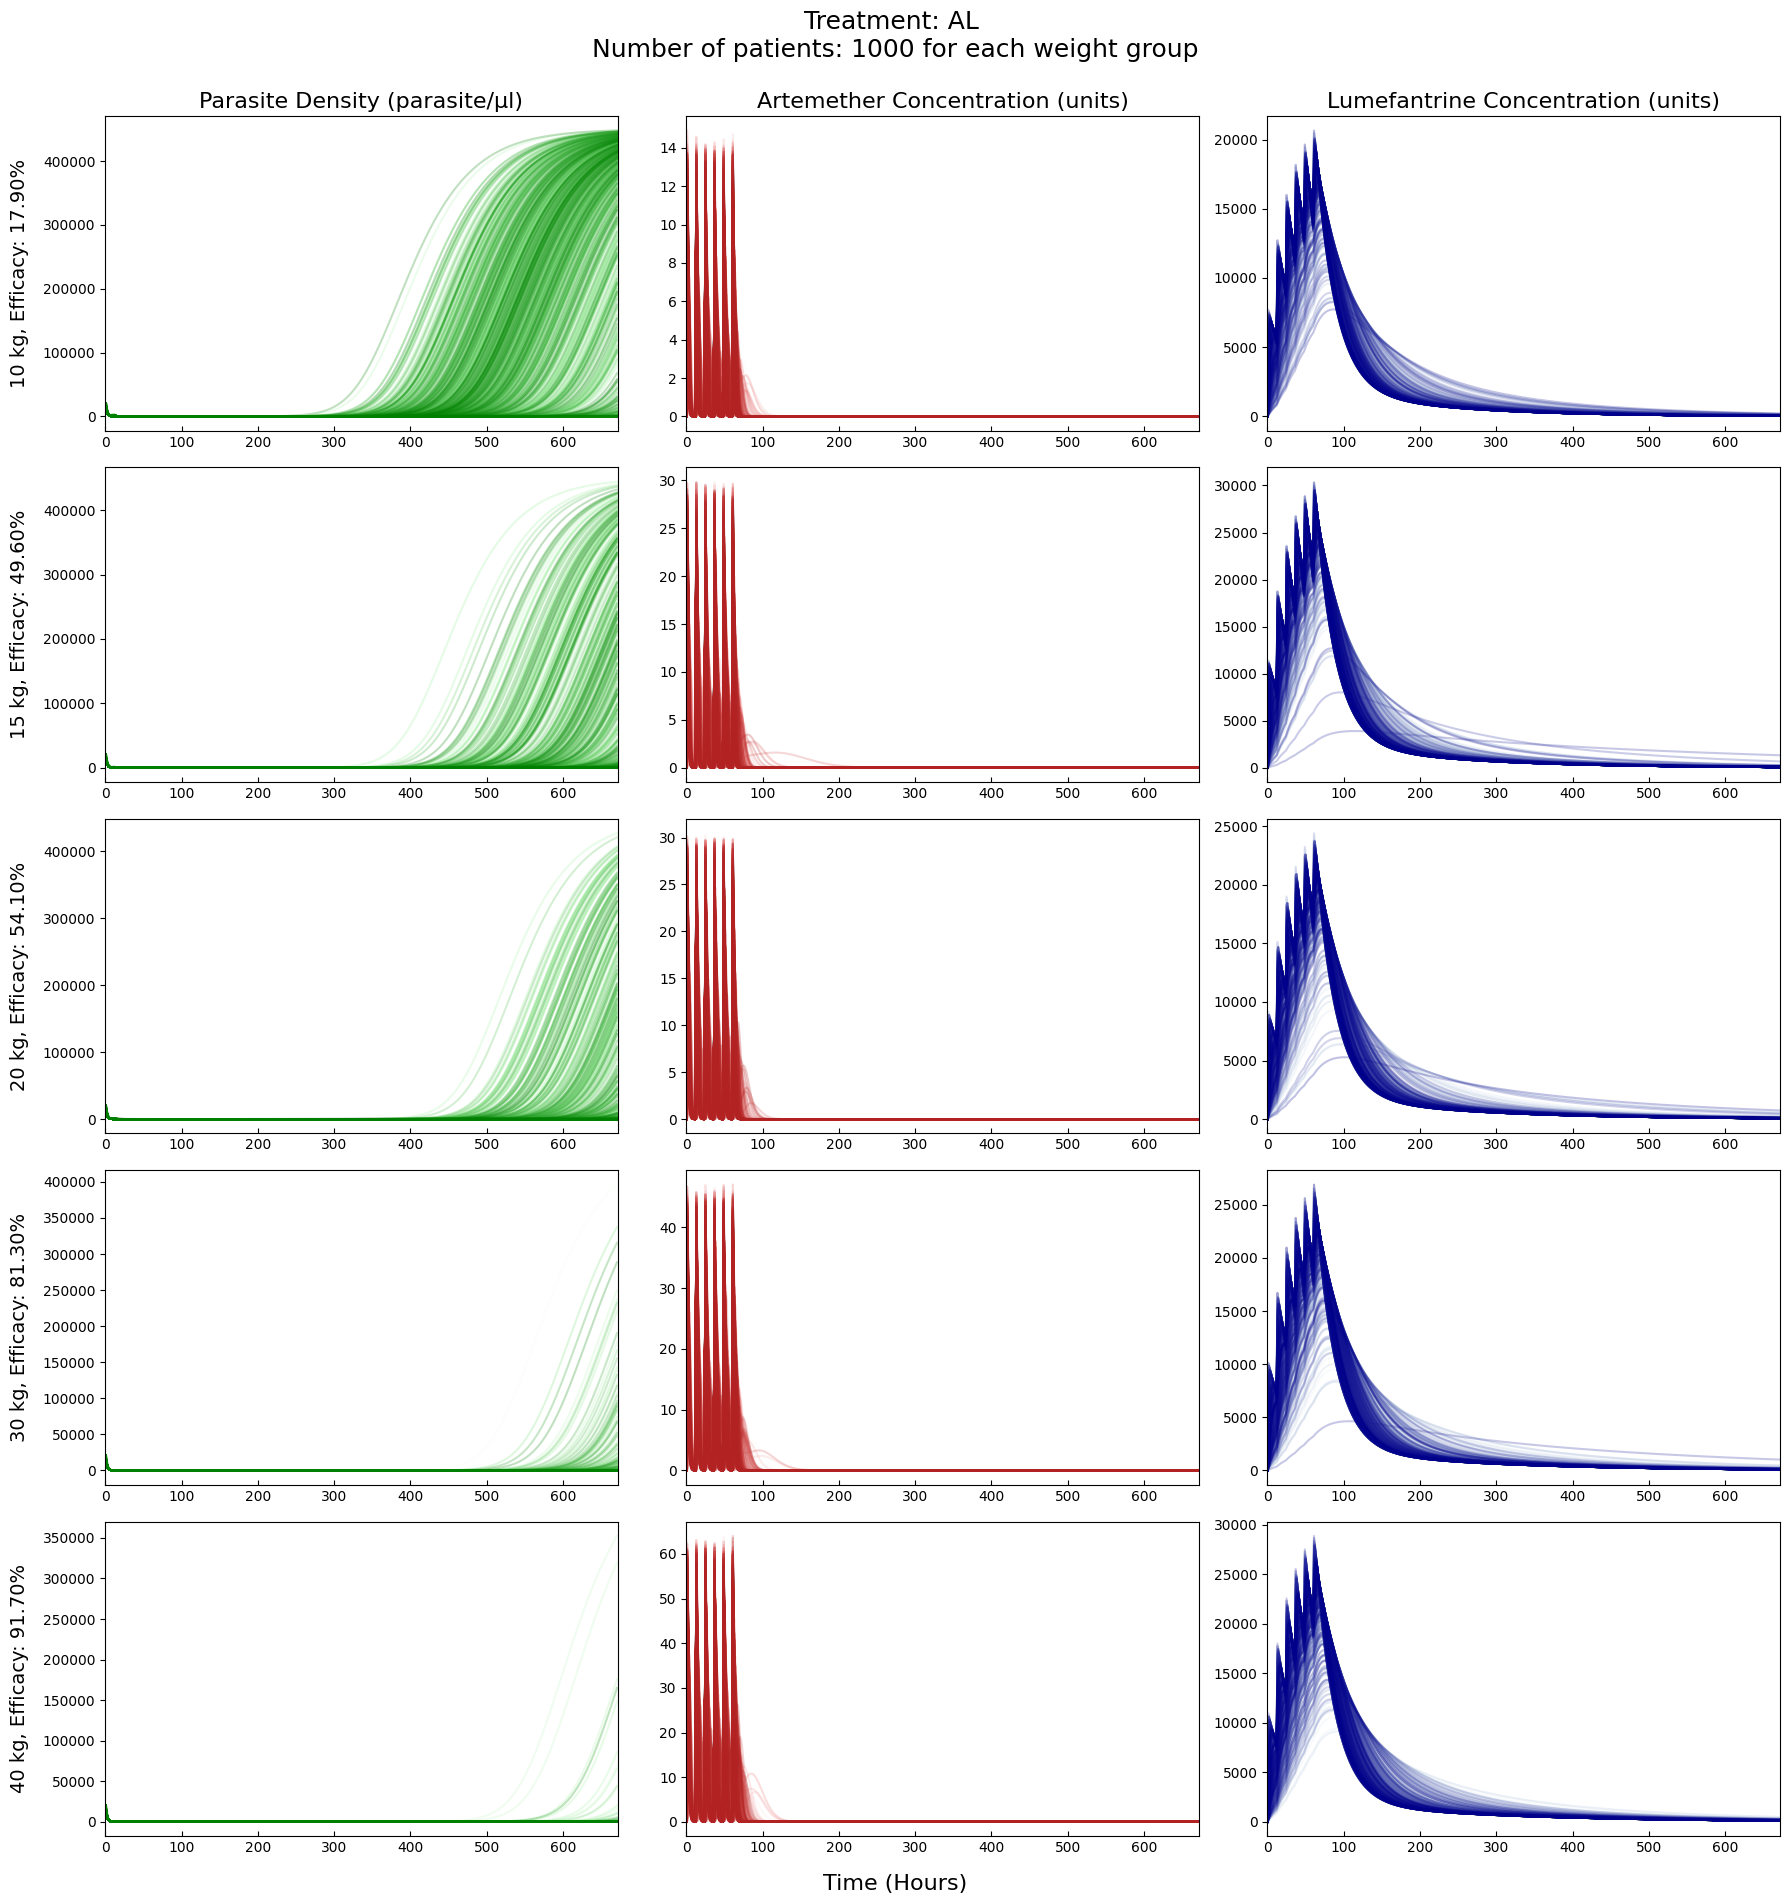

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Load the dataframes
df_weight_10 = pd.read_pickle("df_weight_group_01_10kg.pyobj")
df_weight_15 = pd.read_pickle("df_weight_15kg.pyobj")
df_weight_20 = pd.read_pickle("df_weight_20kg.pyobj")
df_weight_30 = pd.read_pickle("df_weight_30kg.pyobj")
df_weight_40 = pd.read_pickle("df_weight_40kg.pyobj")

# Store DataFrames in a dictionary
df_dict = {10: df_weight_10, 15: df_weight_15, 20: df_weight_20, 30: df_weight_30, 40: df_weight_40}

# Create a 5x3 subplot (5 weight groups, 3 variables per group)
fig, ax = plt.subplots(5, 3, figsize=(18, 20), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 15, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Plot Parasite Density (Column 1) with green colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = green_cmap(norm(j))
        ax[i, 0].plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)

    # Plot Artemether Concentration (Column 2) with red colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[i, 1].plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)

    # Plot Lumefantrine Concentration (Column 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[i, 2].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)

    # Set x-axis limits
    for j in range(3):
        ax[i, j].set_xlim(0, 672)

    # Set row labels on the **leftmost** subplots
    ax[i, 0].set_ylabel(f'{weight} kg, Efficacy: {df_efficacies[df_efficacies["weight"] == weight]["efficacy"].values[0]:.2f}%', fontsize=14, rotation=90, labelpad=10)

# Set **column titles** (only for the top row)
column_titles = ["Parasite Density (parasite/μl)", "Artemether Concentration (units)", "Lumefantrine Concentration (units)"]
for j in range(3):
    ax[0, j].set_title(column_titles[j], fontsize=16)

# Set x-ticks for all subplots
for i in range(4):  
    for j in range(3):
        ax[i, j].tick_params(labelbottom=True)

# Adjust tick direction to "in" (points inward)
for ax_row in ax:
    for subplot in ax_row:
        subplot.tick_params(axis='x', direction='in')

# Add **one shared X-axis label at the bottom**
fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

# Add a **common title** for the whole figure
fig.suptitle('Treatment: AL \nNumber of patients: 1000 for each weight group', fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig("df_weight_all_params_all_weights_multicolour.png")
plt.show()


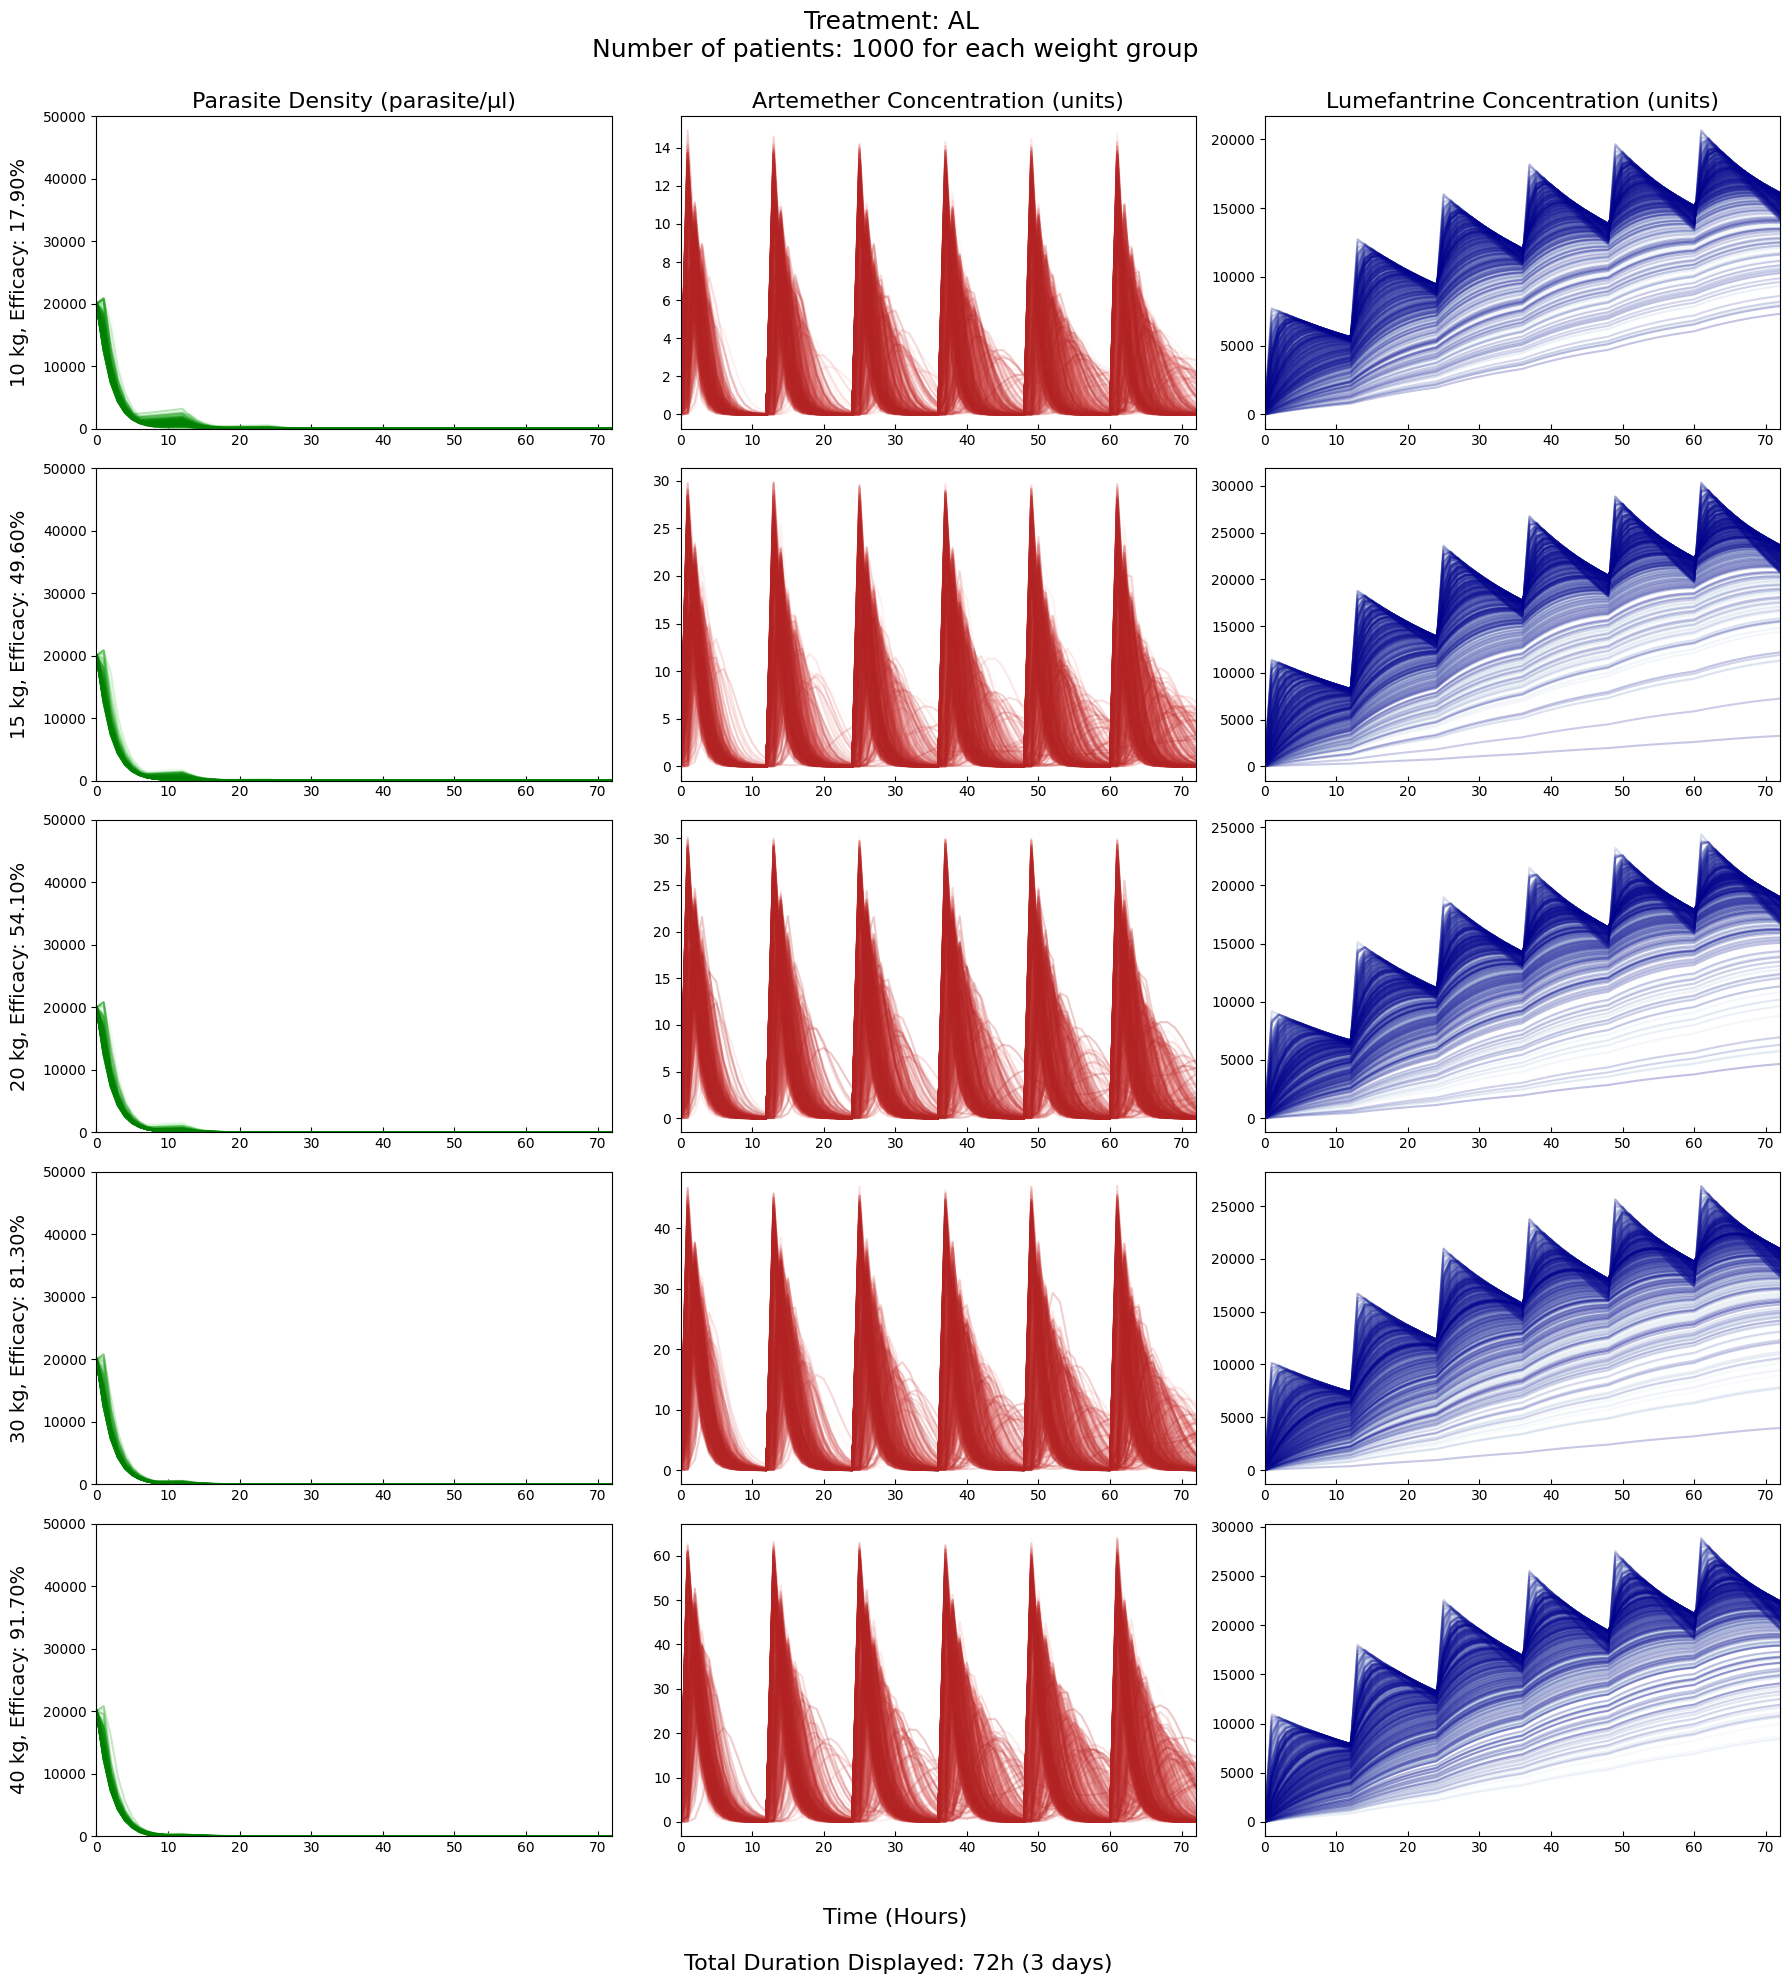

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Load the dataframes
df_weight_10 = pd.read_pickle("df_weight_group_01_10kg.pyobj")
df_weight_15 = pd.read_pickle("df_weight_15kg.pyobj")
df_weight_20 = pd.read_pickle("df_weight_20kg.pyobj")
df_weight_30 = pd.read_pickle("df_weight_30kg.pyobj")
df_weight_40 = pd.read_pickle("df_weight_40kg.pyobj")

# Store DataFrames in a dictionary
df_dict = {10: df_weight_10, 15: df_weight_15, 20: df_weight_20, 30: df_weight_30, 40: df_weight_40}

# Create a 5x3 subplot (5 weight groups, 3 variables per group)
fig, ax = plt.subplots(5, 3, figsize=(18, 20), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 15, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Plot Parasite Density (Column 1) with green colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = green_cmap(norm(j))
        ax[i, 0].plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
        #Changing the y-axis limits to 0 - 100
        ax[i, 0].set_ylim(0, 50000)

    # Plot Artemether Concentration (Column 2) with red colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[i, 1].plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)

    # Plot Lumefantrine Concentration (Column 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[i, 2].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)

    # Set x-axis limits
    for j in range(3):
        ax[i, j].set_xlim(0, 72)

    # Set row labels on the **leftmost** subplots
    ax[i, 0].set_ylabel(f'{weight} kg, Efficacy: {df_efficacies[df_efficacies["weight"] == weight]["efficacy"].values[0]:.2f}%', fontsize=14, rotation=90, labelpad=10)

# Set **column titles** (only for the top row)
column_titles = ["Parasite Density (parasite/μl)", "Artemether Concentration (units)", "Lumefantrine Concentration (units)"]
for j in range(3):
    ax[0, j].set_title(column_titles[j], fontsize=16)

# Set x-ticks for all subplots
for i in range(4):  
    for j in range(3):
        ax[i, j].tick_params(labelbottom=True)

# Adjust tick direction to "in" (points inward)
for ax_row in ax:
    for subplot in ax_row:
        subplot.tick_params(axis='x', direction='in')

# Add **one shared X-axis label at the bottom**
fig.text(0.5, 0, 'Time (Hours)\n\n Total Duration Displayed: 72h (3 days)', ha='center', fontsize=16)

# Add a **common title** for the whole figure
fig.suptitle('Treatment: AL \nNumber of patients: 1000 for each weight group', fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig("df_weight_all_params_all_weights_multicolour_72h.png")
plt.show()


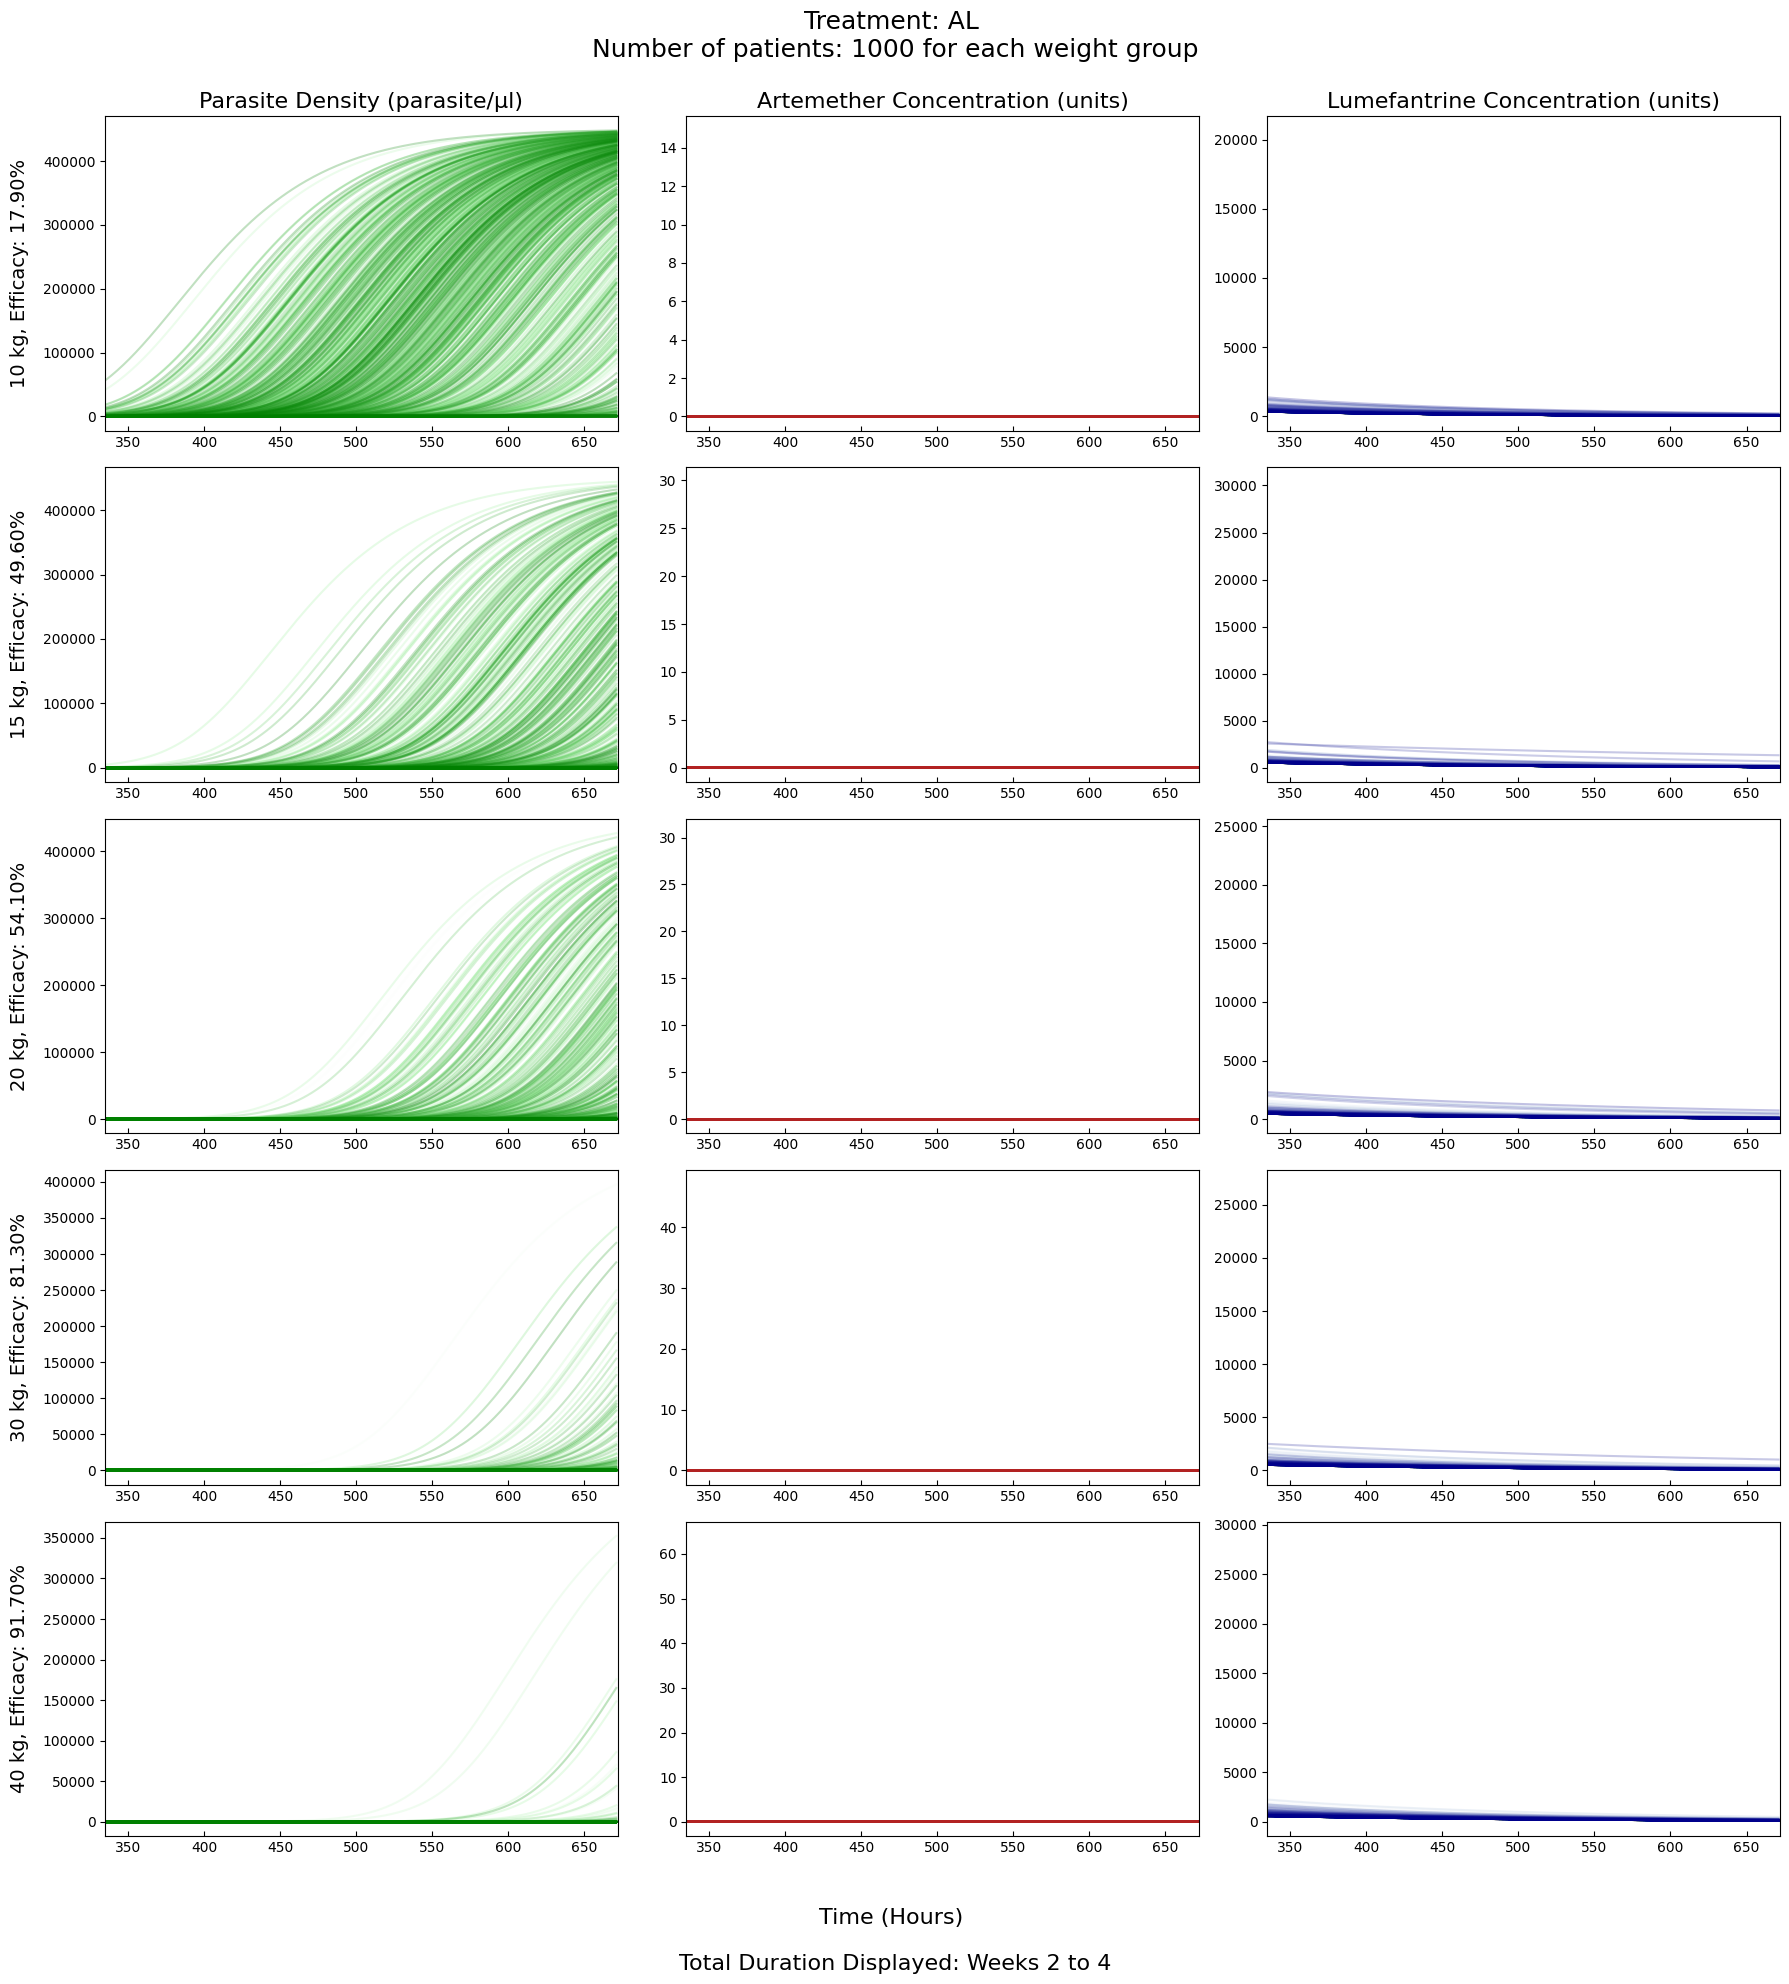

In [93]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Load the dataframes
df_weight_10 = pd.read_pickle("df_weight_group_01_10kg.pyobj")
df_weight_15 = pd.read_pickle("df_weight_15kg.pyobj")
df_weight_20 = pd.read_pickle("df_weight_20kg.pyobj")
df_weight_30 = pd.read_pickle("df_weight_30kg.pyobj")
df_weight_40 = pd.read_pickle("df_weight_40kg.pyobj")

# Store DataFrames in a dictionary
df_dict = {10: df_weight_10, 15: df_weight_15, 20: df_weight_20, 30: df_weight_30, 40: df_weight_40}

# Create a 5x3 subplot (5 weight groups, 3 variables per group)
fig, ax = plt.subplots(5, 3, figsize=(18, 20), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 15, 20, 30, 40]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    # Plot Parasite Density (Column 1) with green colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = green_cmap(norm(j))
        ax[i, 0].plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
        #Changing the y-axis limits to 0 - 100
        #ax[i, 0].set_ylim(0, 50000)

    # Plot Artemether Concentration (Column 2) with red colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[i, 1].plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)

    # Plot Lumefantrine Concentration (Column 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[i, 2].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)

    # Set x-axis limits
    for j in range(3):
        ax[i, j].set_xlim(335, 672)

    # Set row labels on the **leftmost** subplots
    ax[i, 0].set_ylabel(f'{weight} kg, Efficacy: {df_efficacies[df_efficacies["weight"] == weight]["efficacy"].values[0]:.2f}%', fontsize=14, rotation=90, labelpad=10)

# Set **column titles** (only for the top row)
column_titles = ["Parasite Density (parasite/μl)", "Artemether Concentration (units)", "Lumefantrine Concentration (units)"]
for j in range(3):
    ax[0, j].set_title(column_titles[j], fontsize=16)

# Set x-ticks for all subplots
for i in range(4):  
    for j in range(3):
        ax[i, j].tick_params(labelbottom=True)

# Adjust tick direction to "in" (points inward)
for ax_row in ax:
    for subplot in ax_row:
        subplot.tick_params(axis='x', direction='in')

# Add **one shared X-axis label at the bottom**
fig.text(0.5, 0, 'Time (Hours) \n\nTotal Duration Displayed: Weeks 2 to 4', ha='center', fontsize=16)

# Add a **common title** for the whole figure
fig.suptitle('Treatment: AL \nNumber of patients: 1000 for each weight group', fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig("df_weight_all_params_all_weights_multicolour_336h_672h.png")
plt.show()


In [2]:
# Checking if we are in the correct directory
#wd()

# Define the range for weight groups
min_weight = 6
max_weight = 60

# Define pmax_art values
weight_values = list(range(min_weight, max_weight+1, 1))
print(weight_values)
print(len(weight_values))

#Saving EC50_lum for future reference
np.savetxt('pkpd_AL_weight_calibration_weight_range_01.txt', weight_values, delimiter=',', fmt='%5f')

# Initialize a grid to store the clearance rates
trial_efficacy = np.zeros(len(weight_values))

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
55


In [3]:
def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "--pmax_artemether","0.999999",
        "--pmax_lum","0",
        "-n", "1000",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    trial_efficacy[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file
0.
df.to_pickle("pkpd_AL_weight_calibration_artemether.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_calibration_artemether.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 55/55 [02:58<00:00,  3.24s/it]  

DataFrame saved as pickle and CSV files successfully.


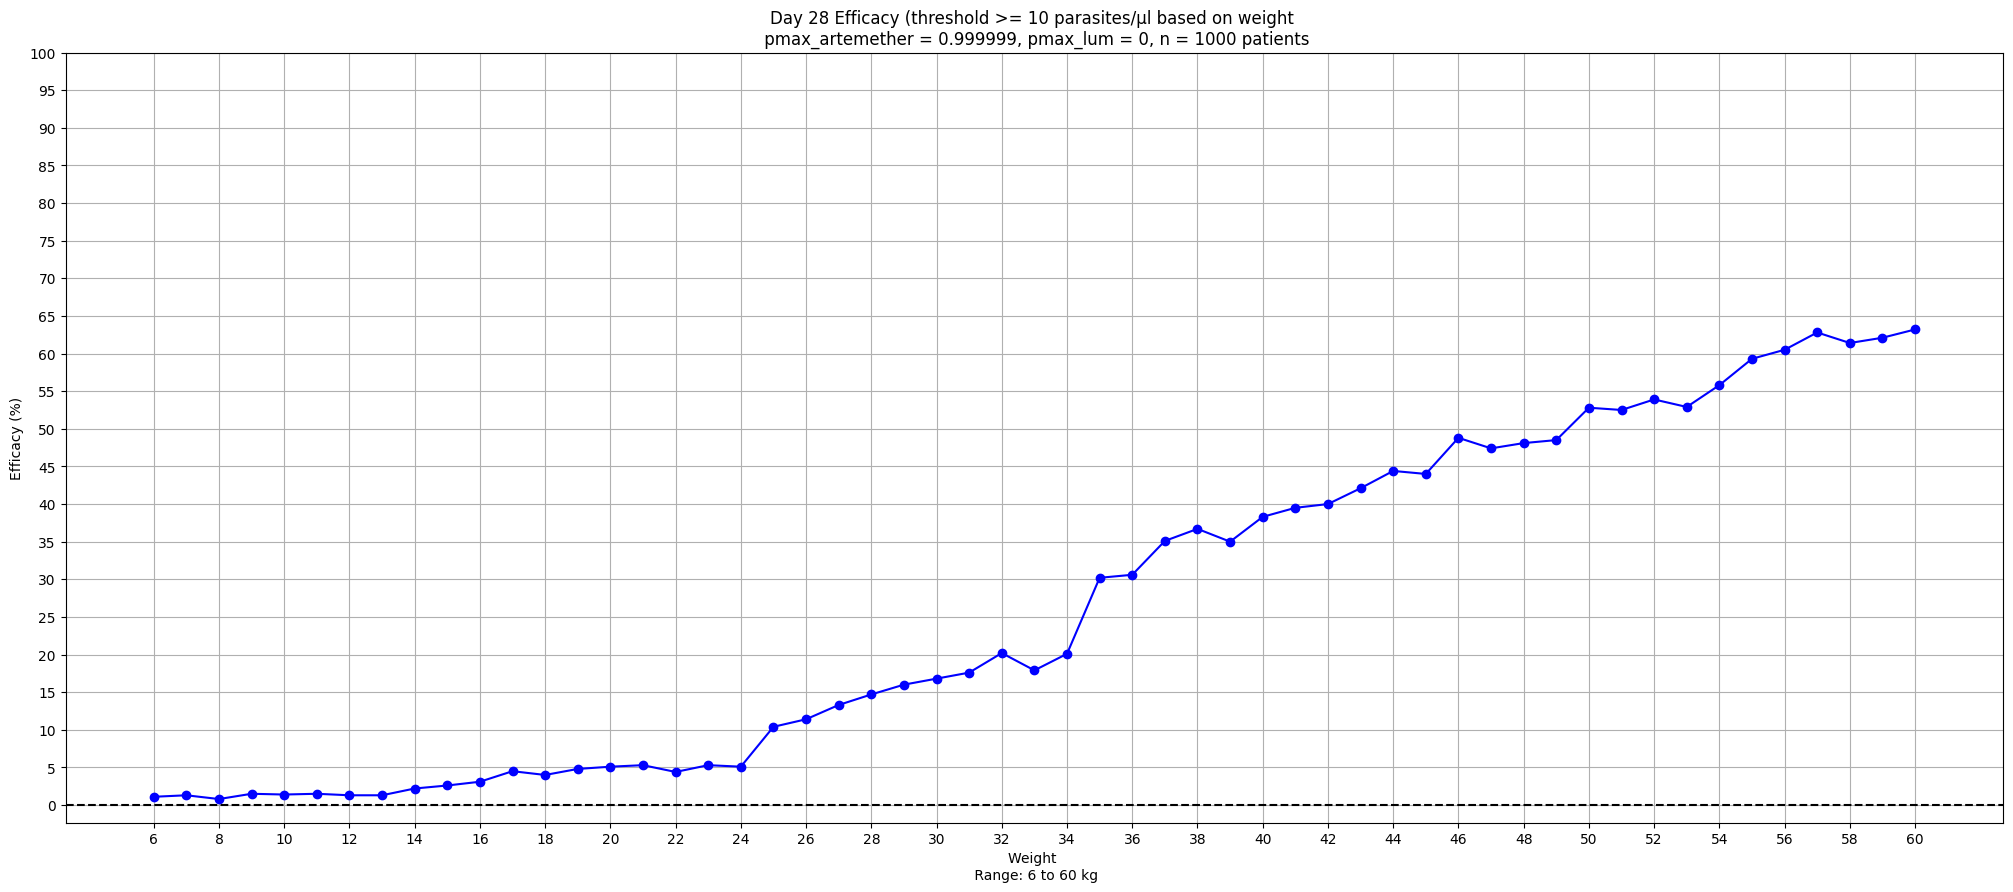

In [4]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, trial_efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('Weight \n Range: 6 to 60 kg')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl based on weight \n pmax_artemether = 0.999999, pmax_lum = 0, n = 1000 patients")
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_calibration_artemether.png")  # Save the plot as a PNG file
plt.show()

In [5]:
# Checking if we are in the correct directory
#wd()

# Define the range for weight groups
min_weight = 6
max_weight = 60

# Define pmax_art values
weight_values = list(range(min_weight, max_weight+1, 1))
print(weight_values)
print(len(weight_values))

#Saving EC50_lum for future reference
np.savetxt('pkpd_AL_weight_calibration_weight_range_01.txt', weight_values, delimiter=',', fmt='%5f')

# Initialize a grid to store the clearance rates
trial_efficacy = np.zeros(len(weight_values))

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
55


In [8]:
def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "--pmax_artemether","0",
        "-n", "1000",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    trial_efficacy[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_weight_calibration_lumefantrine.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_calibration_lumefantrine.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 55/55 [02:57<00:00,  3.23s/it]  

DataFrame saved as pickle and CSV files successfully.


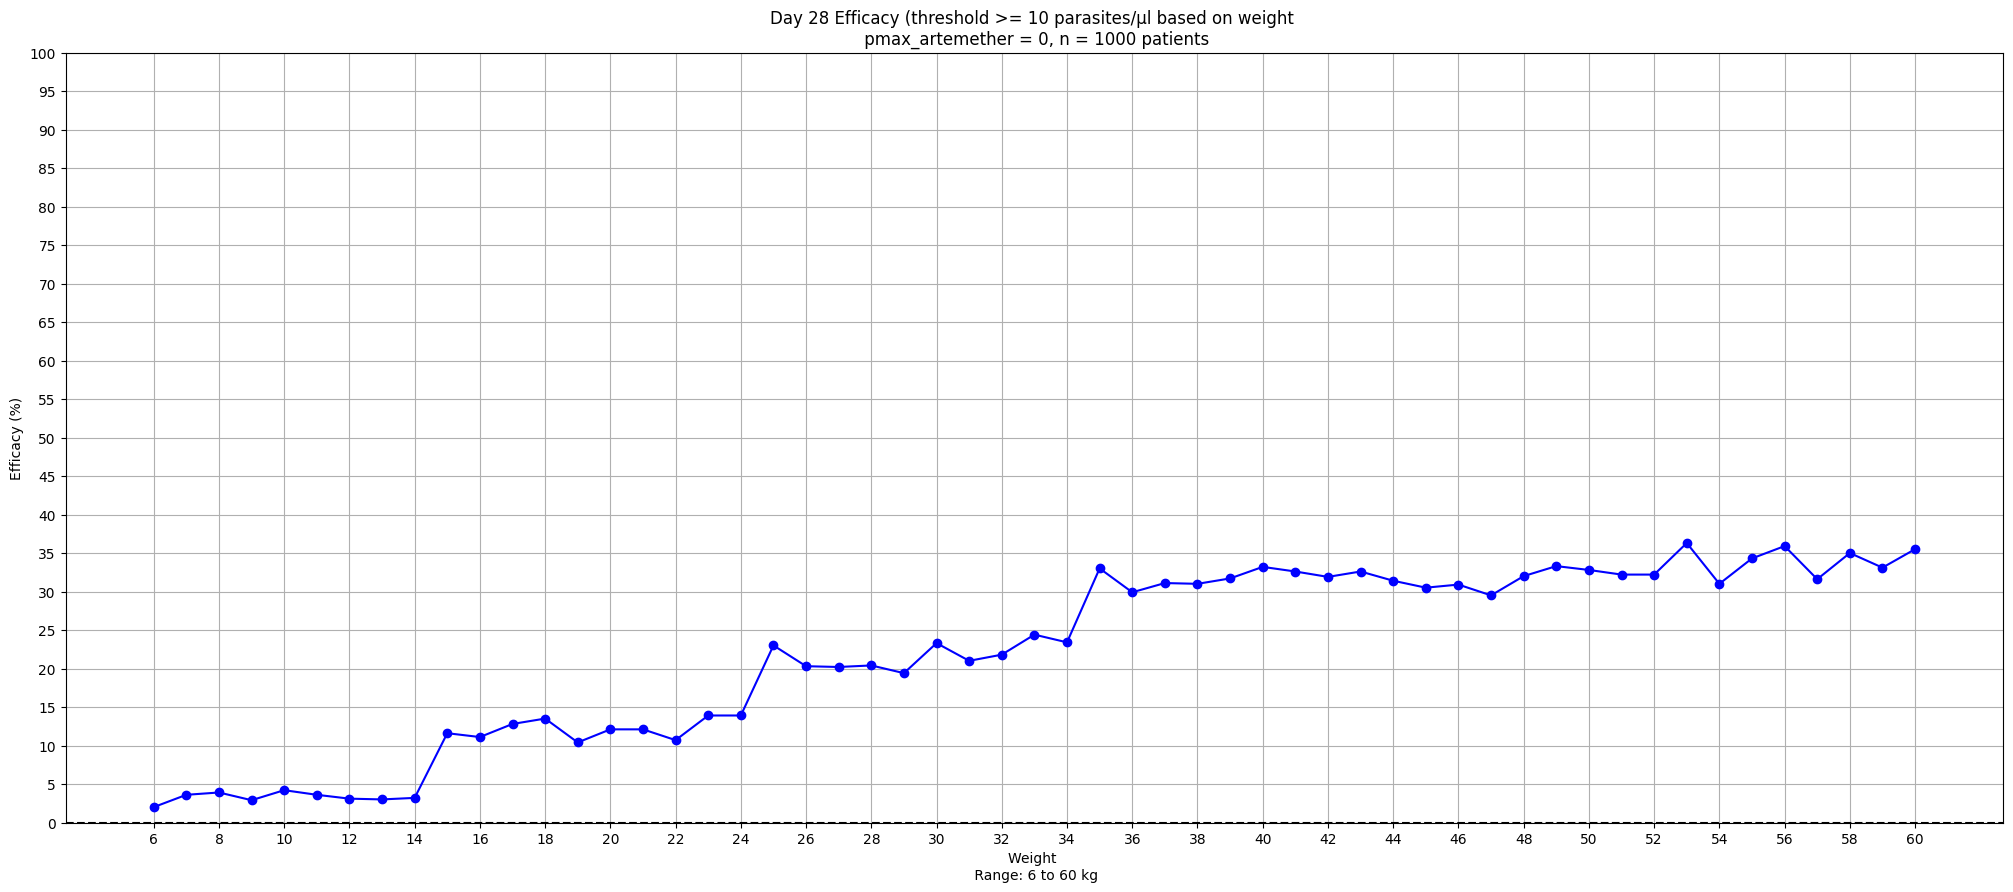

In [9]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, trial_efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('Weight \n Range: 6 to 60 kg')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl based on weight \n pmax_artemether = 0, n = 1000 patients")
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_calibration_lumefantrine.png")  # Save the plot as a PNG file
plt.show()

In [10]:
def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "--pmax_artemether","0.999999",
        "-n", "1000",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    trial_efficacy[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file
0.
df.to_pickle("pkpd_AL_weight_calibration_AL.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_calibration_AL.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 55/55 [03:17<00:00,  3.59s/it]  

DataFrame saved as pickle and CSV files successfully.


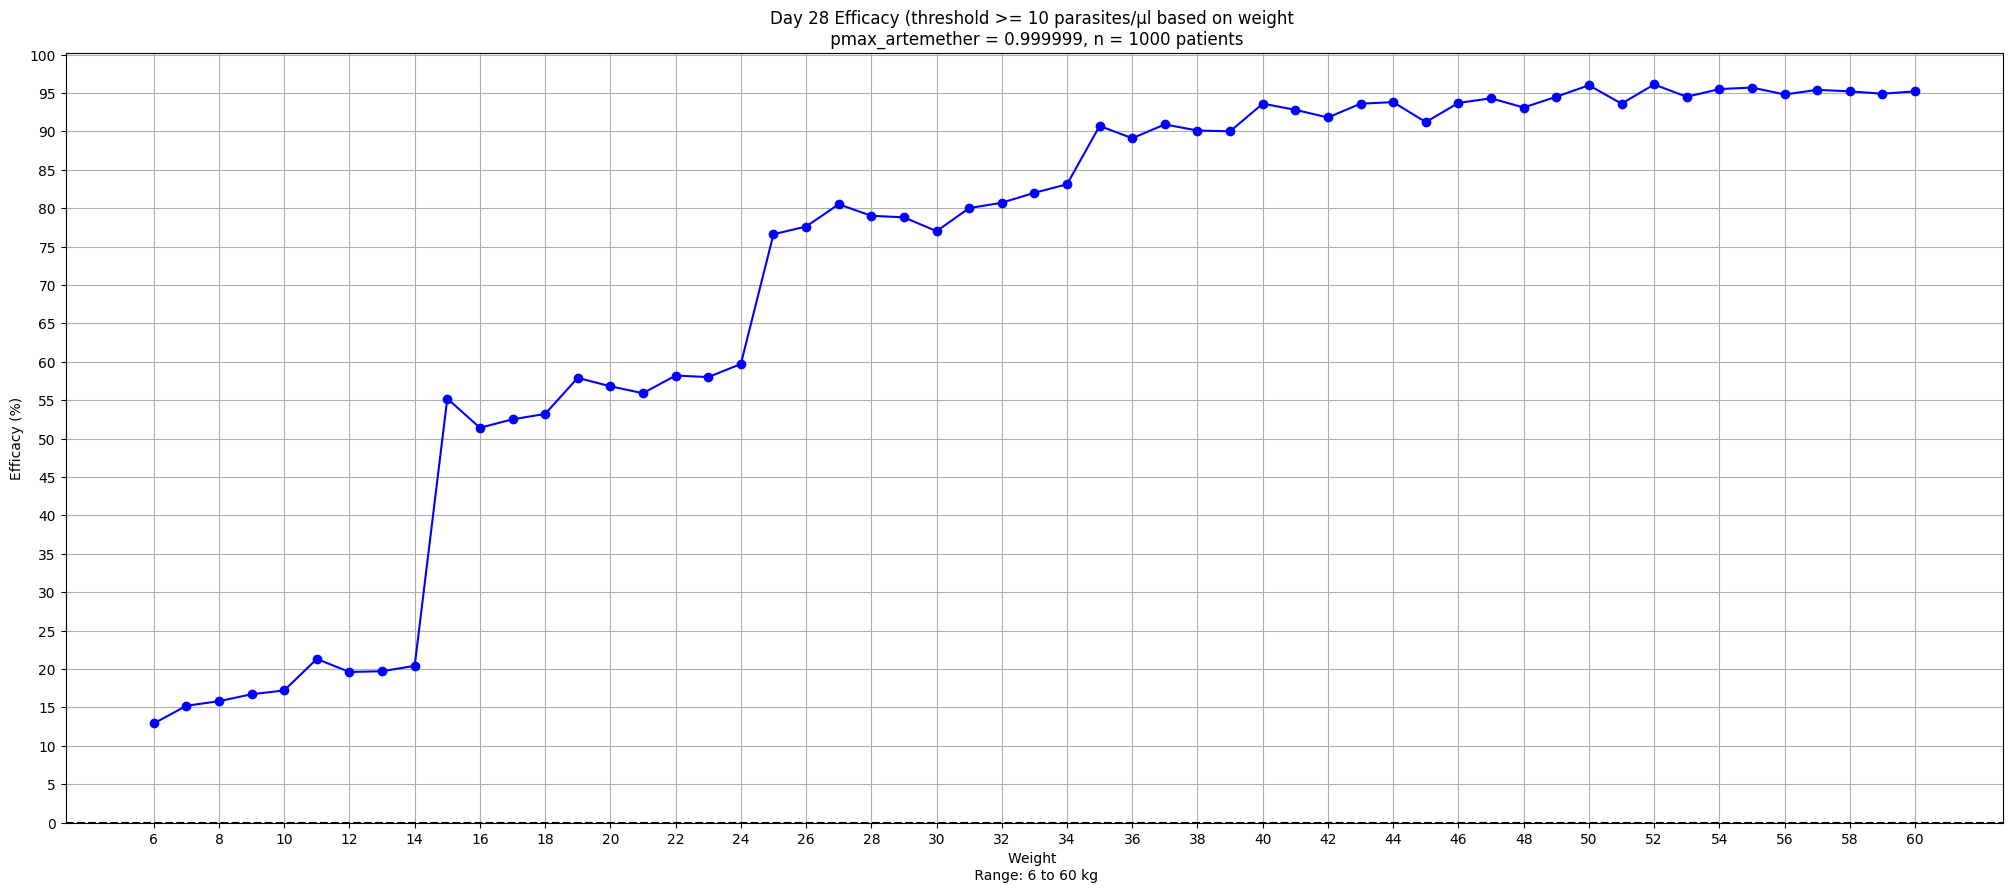

In [11]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, trial_efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('Weight \n Range: 6 to 60 kg')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl based on weight \n pmax_artemether = 0.999999, n = 1000 patients")
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_calibration_AL.png")  # Save the plot as a PNG file
plt.show()

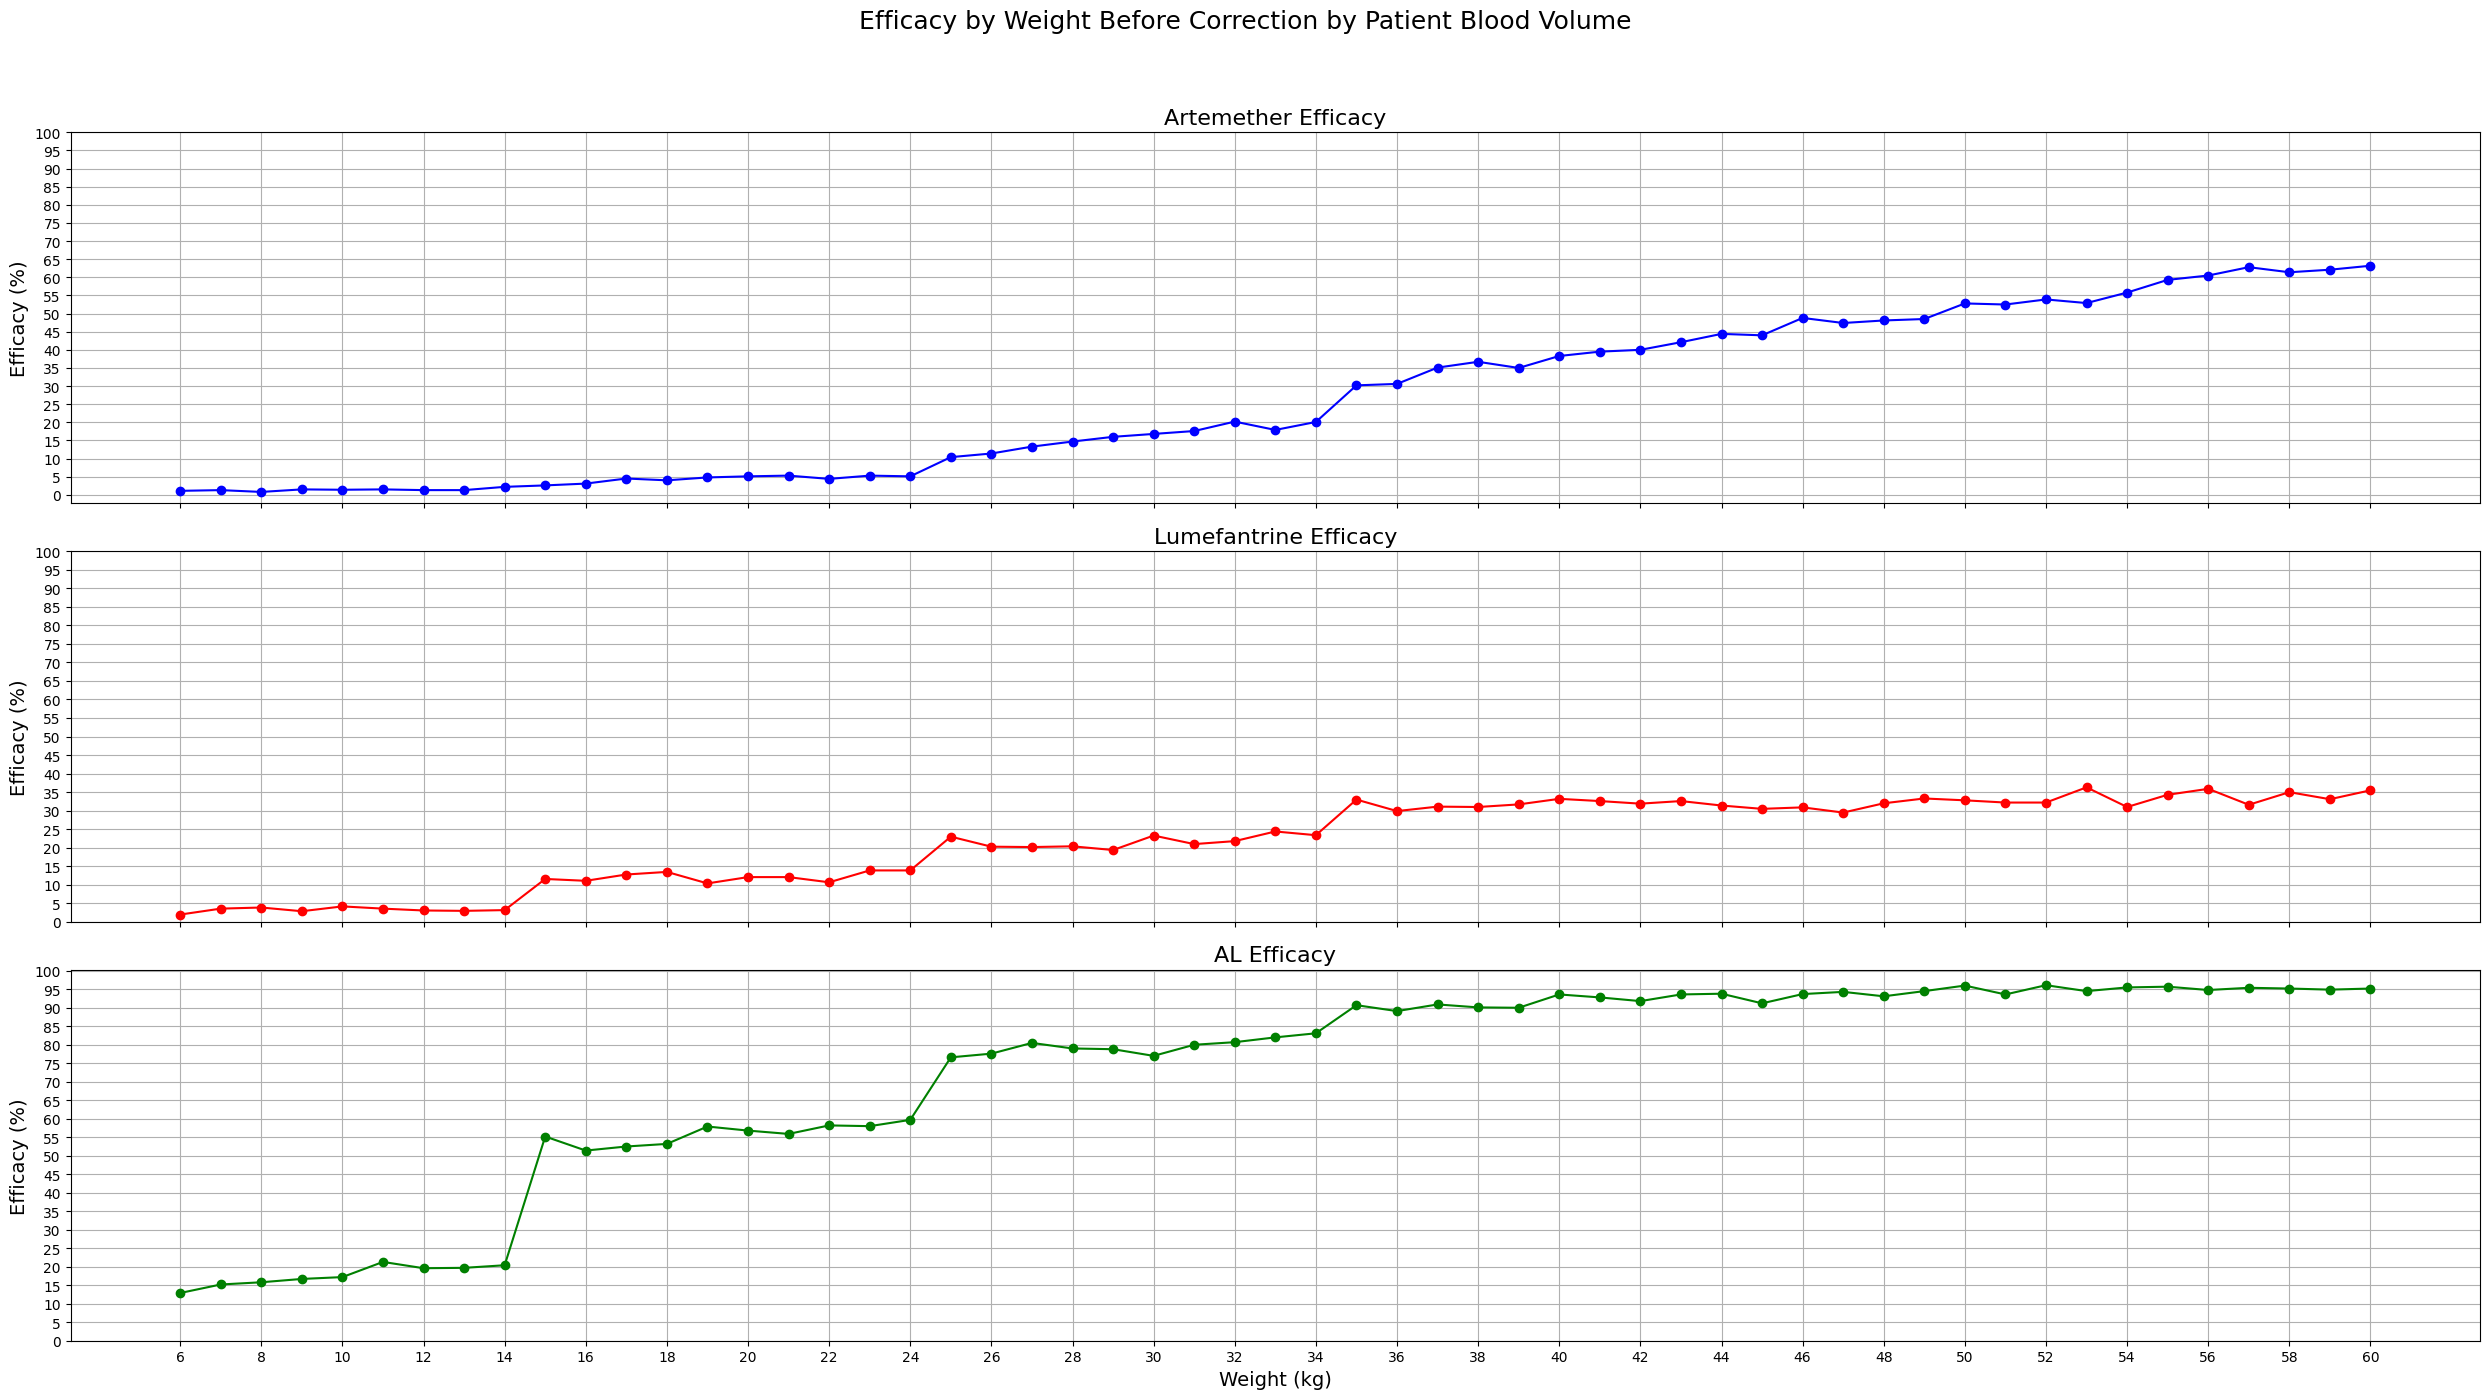

In [14]:
# Loading artemether, lumefantrine, and AL dataframes

df_weight_art = pd.read_pickle("pkpd_AL_weight_calibration_artemether.pyobj")
df_weight_lum = pd.read_pickle("pkpd_AL_weight_calibration_lumefantrine.pyobj")
df_weight_AL = pd.read_pickle("pkpd_AL_weight_calibration_AL.pyobj")

# Plotting the weight vs efficacy for artemether, lumefantrine, and AL as a 3x1 subplot
fig, ax = plt.subplots(3, 1, figsize=(25, 15), sharex=True)
# Plotting artemether efficacy
ax[0].plot(df_weight_art['weight'], df_weight_art['efficacy'], marker='o', linestyle='-', color='b')
ax[0].set_title("Artemether Efficacy", fontsize=16)
ax[0].set_ylabel('Efficacy (%)', fontsize=14)
ax[0].grid(True)
ax[0].set_xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
ax[0].set_yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
# Plotting lumefantrine efficacy
ax[1].plot(df_weight_lum['weight'], df_weight_lum['efficacy'], marker='o', linestyle='-', color='r')
ax[1].set_title("Lumefantrine Efficacy", fontsize=16)
ax[1].set_ylabel('Efficacy (%)', fontsize=14)
ax[1].grid(True)
ax[1].set_xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
ax[1].set_yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
# Plotting AL efficacy
ax[2].plot(df_weight_AL['weight'], df_weight_AL['efficacy'], marker='o', linestyle='-', color='g')
ax[2].set_title("AL Efficacy", fontsize=16)
ax[2].set_xlabel('Weight (kg)', fontsize=14)
ax[2].set_ylabel('Efficacy (%)', fontsize=14)
ax[2].grid(True)
ax[2].set_xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
ax[2].set_yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
# Set common x-axis label
#fig.text(0.5, 0.04, 'Weight (kg)', ha='center', fontsize=16)
# Set common title
fig.suptitle('Efficacy by Weight Before Correction by Patient Blood Volume', fontsize=18)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to fit common x-label
plt.savefig("pkpd_AL_weight_calibration_all_efficacies.png")  # Save the plot as a PNG file
plt.show()



In [3]:
# Checking if we are in the correct directory
#wd()

# Define the range for weight groups
min_weight = 6
max_weight = 60

# Define pmax_art values
weight_values = list(range(min_weight, max_weight+1, 1))
print(weight_values)
print(len(weight_values))

#Saving EC50_lum for future reference
np.savetxt('pkpd_AL_weight_calibration_weight_range_01.txt', weight_values, delimiter=',', fmt='%5f')

# Initialize a grid to store the clearance rates
trial_efficacy = np.zeros(len(weight_values))

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
55


In [6]:
def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "--pmax_artemether","0.999999",
        "--pmax_lum","0",
        "-n", "1000",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    trial_efficacy[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file
0.
df.to_pickle("pkpd_AL_weight_calibration_artemether_patient_blood_volume.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_calibration_artemether_patient_blood_volume.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 55/55 [02:55<00:00,  3.18s/it]  

DataFrame saved as pickle and CSV files successfully.


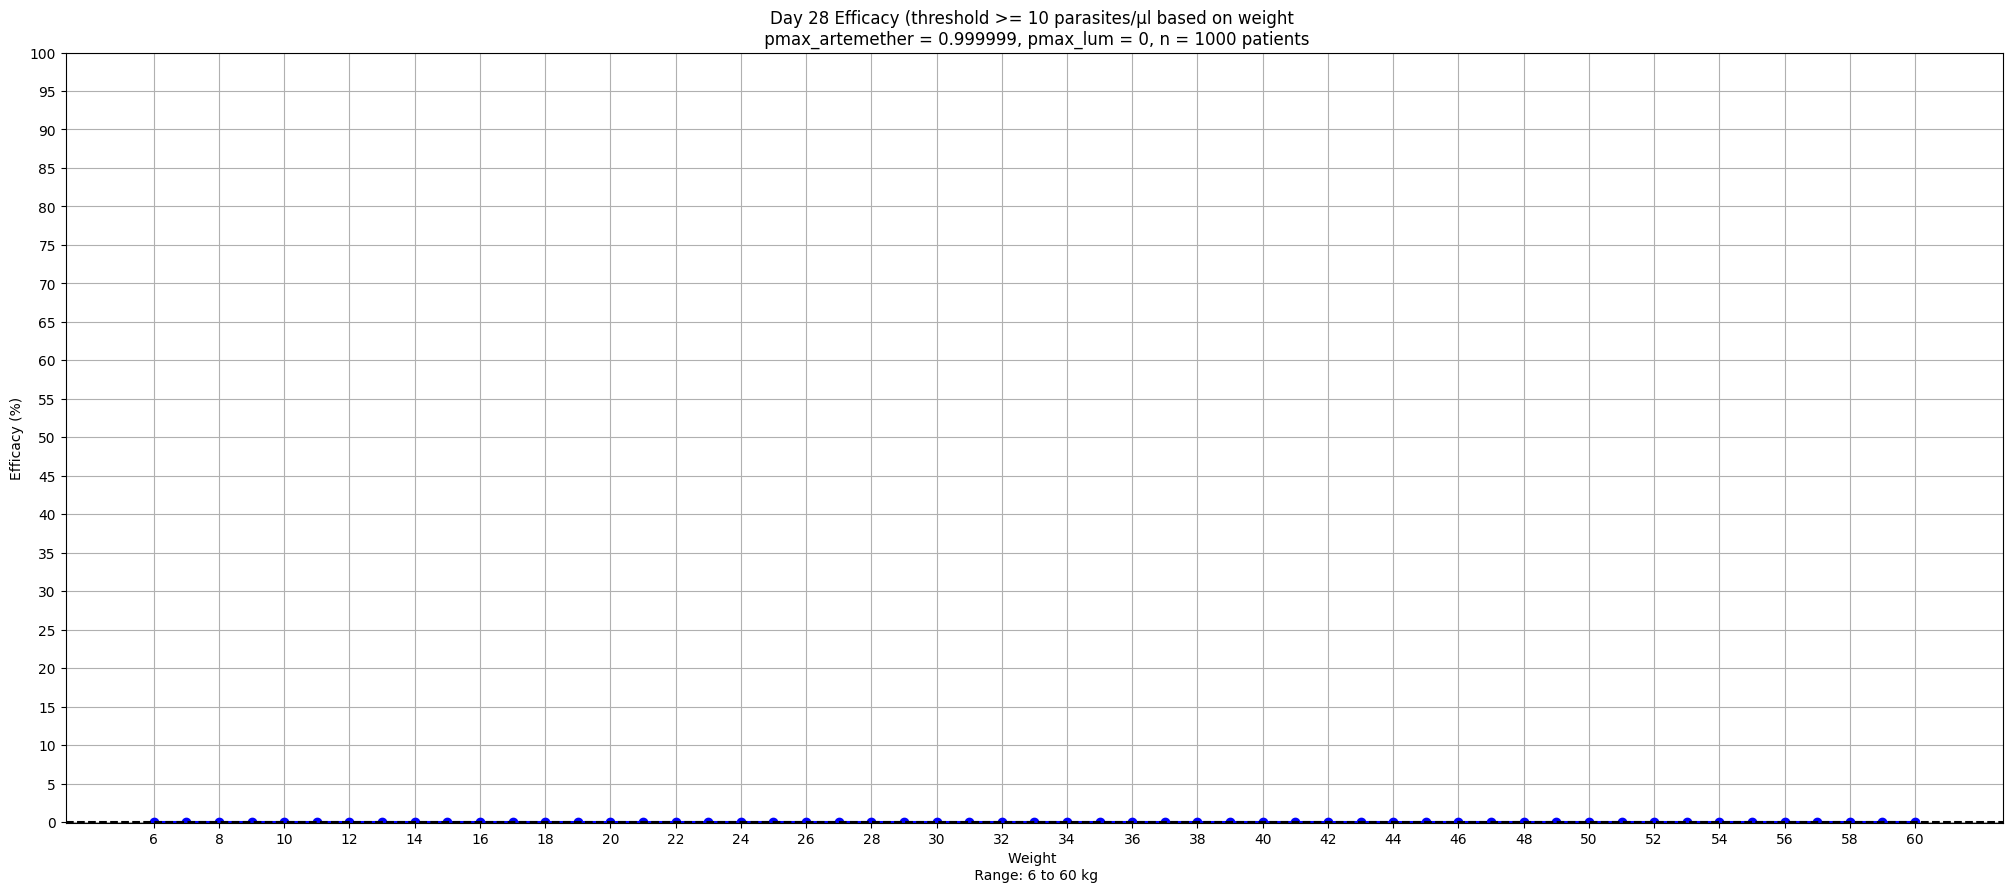

In [ ]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, trial_efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('Weight \n Range: 6 to 60 kg')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl based on weight \n pmax_artemether = 0.999999, pmax_lum = 0, n = 1000 patients")
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_calibration_artemether_patient_blood_volume.png")  # Save the plot as a PNG file
plt.show()

In [8]:
def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "--pmax_artemether","0",
        "-n", "1000",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    trial_efficacy[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file
0.
df.to_pickle("pkpd_AL_weight_calibration_lumefantrine_patient_blood_volume.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_calibration_lumefantrine_patient_blood_volume.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 55/55 [02:56<00:00,  3.21s/it]  

DataFrame saved as pickle and CSV files successfully.


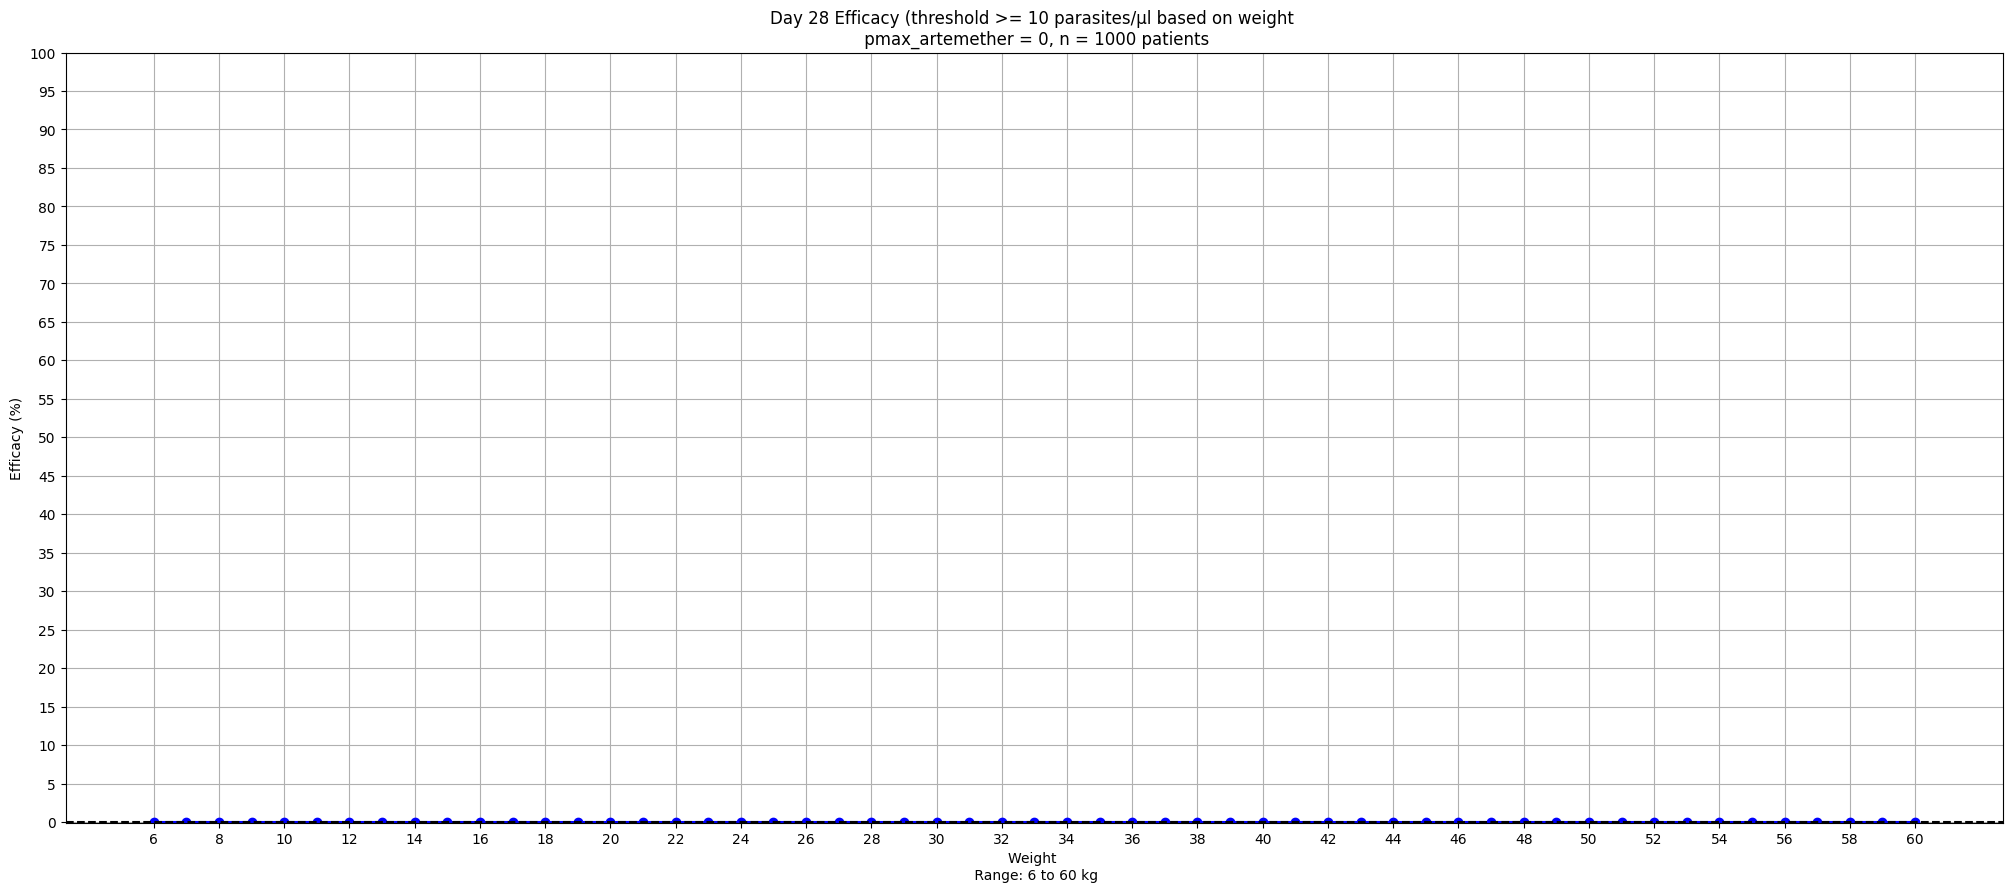

In [ ]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, trial_efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('Weight \n Range: 6 to 60 kg')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl based on weight \n pmax_artemether = 0, n = 1000 patients")
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_calibration_lumefantrine_patient_blood_volume.png")  # Save the plot as a PNG file
plt.show()

In [10]:
def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "--pmax_artemether","0.999999",
        "-n", "1000",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    trial_efficacy[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file
0.
df.to_pickle("pkpd_AL_weight_calibration_AL_patient_blood_volume.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_calibration_AL_patient_blood_volume.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 55/55 [03:00<00:00,  3.28s/it]  

DataFrame saved as pickle and CSV files successfully.


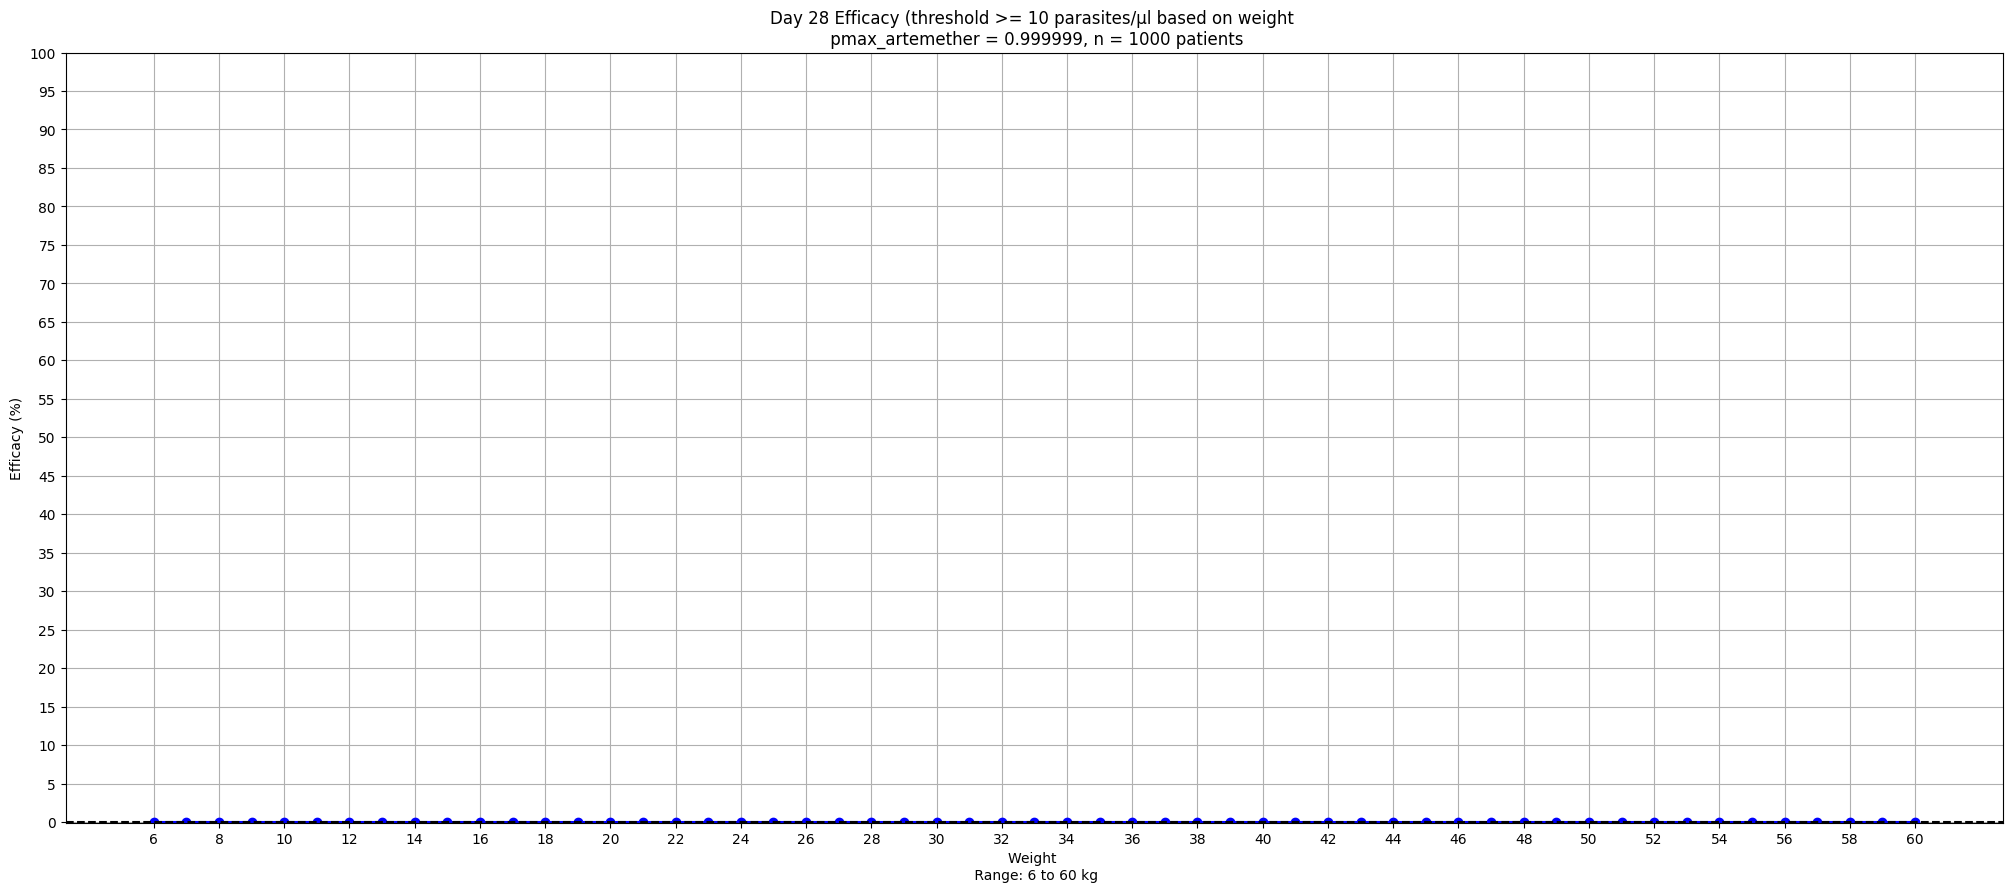

In [ ]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, trial_efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('Weight \n Range: 6 to 60 kg')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl based on weight \n pmax_artemether = 0.999999, n = 1000 patients")
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_calibration_AL)patient_blood_volume.png")  # Save the plot as a PNG file
plt.show()

In [14]:
def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "--pmax_artemether","0.999999",
        "-n", "1000",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    trial_efficacy[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file
0.
df.to_pickle("pkpd_AL_weight_calibration_AL_lumfantrine_CentralVolumeOfDistribution.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_calibration_AL_lumfantrine_CentralVolumeOfDistribution.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 55/55 [03:12<00:00,  3.51s/it]  

DataFrame saved as pickle and CSV files successfully.


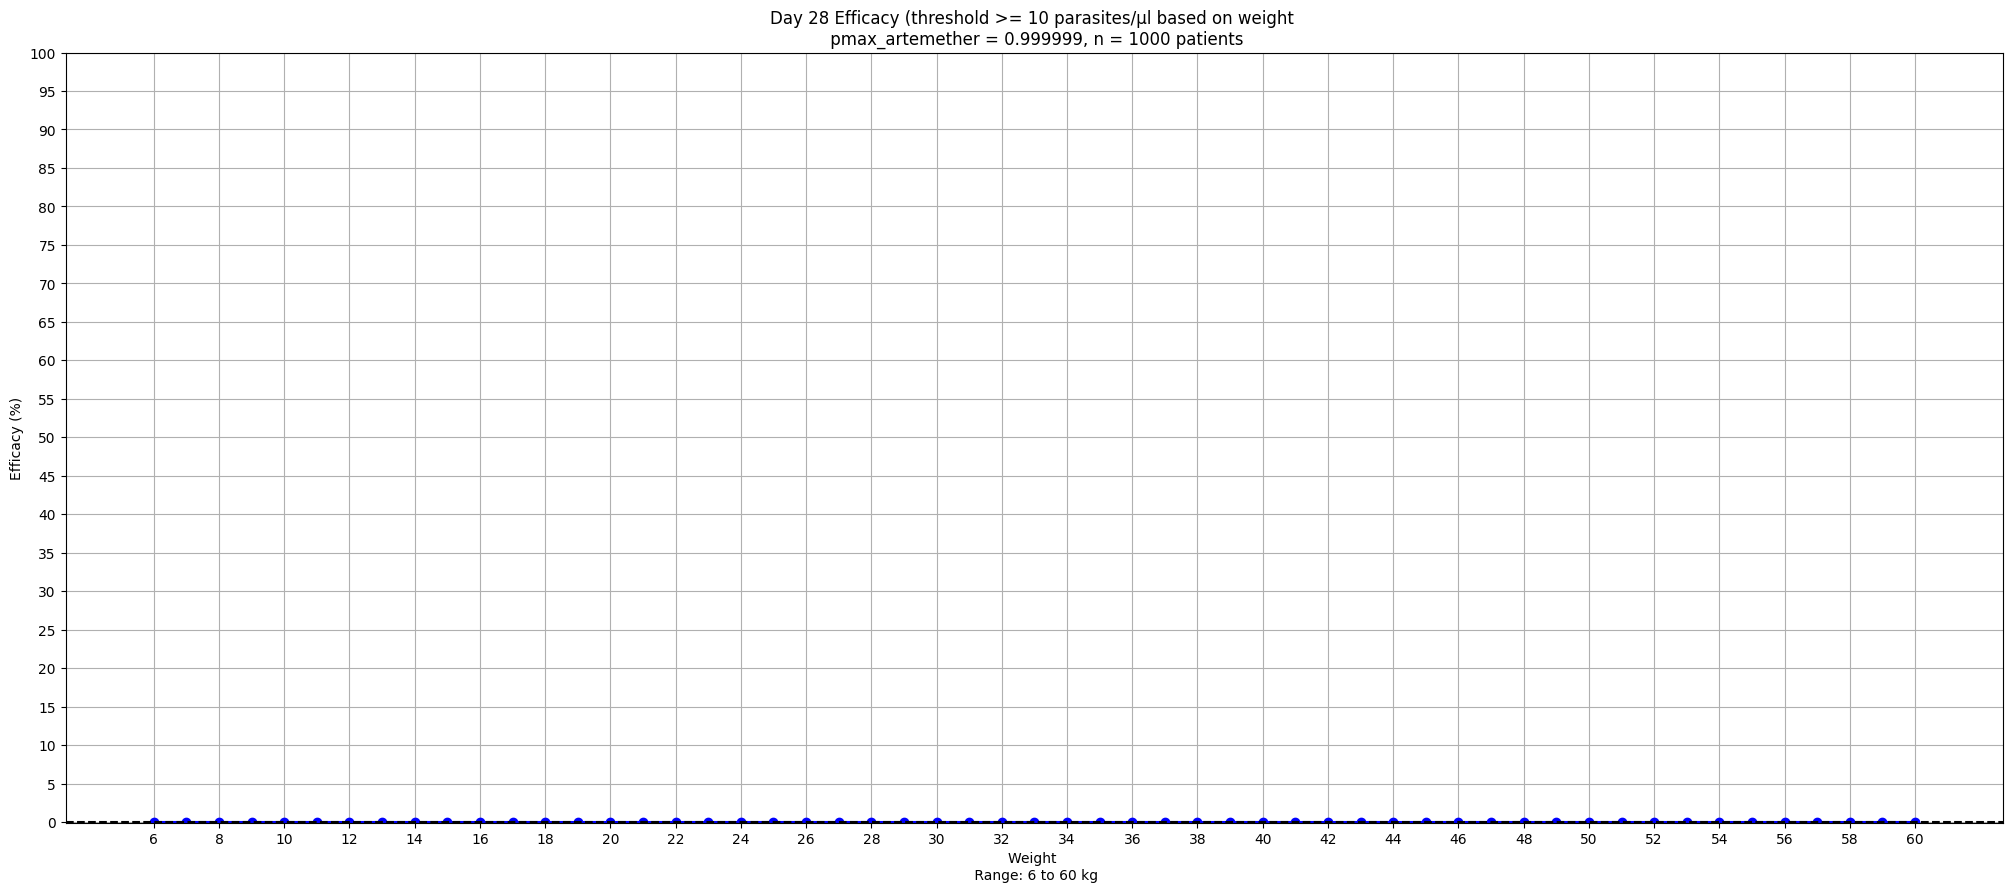

In [15]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, trial_efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('Weight \n Range: 6 to 60 kg')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl based on weight \n pmax_artemether = 0.999999, n = 1000 patients")
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_calibration_AL_lumfantrine_CentralVolumeOfDistribution.png")  # Save the plot as a PNG file
plt.show()